Datasets used: 
- `adult (Adult)` :<br>The UCI Adult dataset contains 14 features, which can be divided into two categories: demographic and income-related.<br> The demographic features include:

    age: continuous.<br>
    fnlwgt : continuous, represents final weight, which is the number of units in the target population that the responding unit represents.<br>
    workclass: categorical, with values 'Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov', 'State-gov', 'Self-emp-inc', 'Without-pay'.<br>
    education: categorical, with values '11th', 'HS-grad', 'Assoc-acdm', 'Some-college', '10th', ..., '9th', 'Doctorate', '12th', '1st-4th', 'Preschool'.<br>
    education-num: continuous with values 1 to 16, one number assigned to each label of education feature.<br>
    marital-status: categorical, with values 'Never-married', 'Married-civ-spouse', 'Widowed', 'Separated', 'Divorced', 'Married-spouse-absent', 'Married-AF-spouse'.<br>
    occupation: categorical, with values such as 'Machine-op-inspct', 'Farming-fishing', 'Protective-serv'.<br>
    relationship: categorical, with values 'Own-child', 'Husband', 'Not-in-family', 'Unmarried', 'Wife', 'Other-relative'.<br>
    race: categorical, with values such as white, black, and Asian.<br>
    sex: categorical, with values male and female.<br>
    
    The income-related features include:<br>

    hours-per-week: continuous.<br>
    native-country: categorical, with values such as United-States, Mexico, and Germany.<br>
    capital-gain: continuous, represent the amount of money an individual has gained from the sale of investments such as stocks, bonds, or real estate.<br>
    capital-loss: continuous, represent the amount of money an individual has lost from the sale of investments such as stocks, bonds, or real estate..<br>
    The target feature is the income, which is binary:<br>
    income: categorical, with values less than or equal to 50K and greater than 50K.<br>

Reference Links: https://archive.ics.uci.edu/ml/datasets/adult

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import facts
from facts.clean import clean_dataset
from facts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from facts.models import customLogisticRegression
from facts.parameters import ParameterProxy
from facts.formatting import recourse_report_reverse, print_recourse_report, print_recourse_report_cumulative,print_recourse_report_KStest_cumulative
import matplotlib.pyplot as plt

from IPython.display import Markdown, display

In [2]:
urlfile= "https://raw.githubusercontent.com/columbia/fairtest/master/data/adult/adult.csv"

X = pd.read_csv(urlfile)
df = clean_dataset(X, "adult")

age = [val.left for val in df.age.unique()]
age.sort()

df.head()

,age,Workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,"(34.0, 41.0]",State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,FullTime,United-States,0
1,"(41.0, 50.0]",Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Married,White,Male,0,0,PartTime,United-States,0
2,"(34.0, 41.0]",Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,FullTime,United-States,0
3,"(50.0, 90.0]",Private,7,Married-civ-spouse,Handlers-cleaners,Married,Black,Male,0,0,FullTime,United-States,0
4,"(26.0, 34.0]",Private,13,Married-civ-spouse,Prof-specialty,Married,Black,Female,0,0,FullTime,Cuba,0


In [3]:
y = df['income']
X = df.drop('income', axis=1)

num_features = X._get_numeric_data().columns.to_list()
cate_features = X.select_dtypes(include=['object','category']).columns.to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=None, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [4]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='income')
model.predict(X_test.iloc[:100, :])

CPU times: total: 1.94 s
Wall time: 3.54 s


array([0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [5]:
positive_label = 1
negative_label = 0
preds_Xtest = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds_Xtest))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90     10205
           1       0.74      0.60      0.66      3362

    accuracy                           0.85     13567
   macro avg       0.81      0.77      0.78     13567
weighted avg       0.84      0.85      0.84     13567



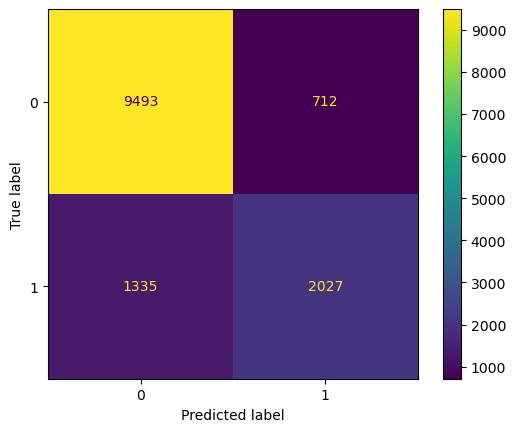

In [6]:
conf_matrix = confusion_matrix(y_test, preds_Xtest)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

In [7]:
# #Uncomment if you want to find new rules with different support

# ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
#     X_test,
#     model=model,
#     sensitive_attribute='sex',
#     freqitem_minsupp = 0.01,
#     missing_subgroup_val="Unknown",
#     drop_infeasible = True,
#     drop_above = True
# )

# print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
# rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

In [8]:
from facts.utils import load_rules_by_if, save_rules_by_if

## Use this for loading rules from disk
rules_by_if = load_rules_by_if("rulesAdultFairTest_preproc.data")

## Use this for saving rules on disk
# save_rules_by_if("rulesAdultFairTest_preproc.data", rules_by_if)

In [9]:
# # run this section if you load data from disk that are computed with drop_infeasible,drop_above flags as False

# from facts.predicate import drop_two_above
# ifthens = facts.rulesbyif2rules(rules_by_if)
# ifthens = [(ifs,then,cov,cor) for ifs,then,cov,cor in ifthens if facts.recIsValid(ifs,then,X_test,True)]
# ifthens = [(ifs,then,cov,cor) for ifs,then,cov,cor in ifthens if drop_two_above(ifs,then,age)]
# rules_by_if = facts.rules2rulesbyif(ifthens)

In [10]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1][" Male"][1][0][1]-e[1][" Female"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If Workclass =  Private, age = (34.0, 41.0], capital-loss = 0, occupation =  Sales, race =  White:
	Protected Subgroup ' Male', 1.16% covered
		Make age = (41.0, 50.0], occupation =  Exec-managerial with correctness 66.67%.
		Make occupation =  Exec-managerial with correctness 56.41%.
		Make age = (41.0, 50.0], occupation =  Prof-specialty with correctness 66.67%.
		Make age = (50.0, 90.0], occupation =  Exec-managerial with correctness 56.41%.
		Make occupation =  Prof-specialty with correctness 50.00%.
		Make age = (50.0, 90.0], occupation =  Prof-specialty with correctness 56.41%.
		Make age = (41.0, 50.0] with correctness 48.72%.
		Make age = (50.0, 90.0] with correctness 23.08%.
		Make Workclass =  Local-gov, age = (41.0, 50.0], occupation =  Prof-specialty with correctness 56.41%.
		Make age = (41.0, 50.0], occupation =  Craft-repair with correctness 0.00%.
		Make Workclass =  Self-emp-inc, age = (50.0, 90.0], occupation =  Exec-managerial with correctness 66.67%.
		Make occupati

## Fairness definitions based on cumulative distribution of cost - correctness

## Calculation of cumulative correctness for all if clauses

In [11]:
feature_weights = {"sex": 1, "age": 1, "relationship": 10, "education-num": 20}
features_with_binary_cost = cate_features
features_with_proportional_cost = num_features


comparators = facts.feature_change_builder(
    X_test,
    num_cols=features_with_proportional_cost,
    cate_cols=features_with_binary_cost,
    feature_weights=feature_weights,
    num_normalization=True
)
params = ParameterProxy(featureChanges=comparators)

In [12]:
rules_with_cumulative = facts.cum_corr_costs_all(rules_by_if, X_test, model, sensitive_attribute="sex", params=params)

100%|████████████████████████████████████████████████████████████████████████████| 12880/12880 [17:35<00:00, 12.20it/s]


In [14]:
## Use this for loading rules from disk
# rules_with_cumulative = load_rules_by_if("rulesAdultFairTest_cumulative.data")

## Use this for saving rules on disk
save_rules_by_if("rulesAdultFairTest_cumulative.data", rules_with_cumulative)

# Fairness of Mean Recourse

If Workclass =  Private, hours-per-week = MidTime, race =  White, relationship =  Married:
	Protected Subgroup ' Male', 2.02% covered out of 6761
		Make hours-per-week = FullTime with correctness 4.44% and counterfactual cost = 1.0.
		Make hours-per-week = OverTime with correctness 17.04% and counterfactual cost = 1.0.
		Make hours-per-week = BrainDrain with correctness 17.04% and counterfactual cost = 1.0.
		Make Workclass =  Self-emp-not-inc, hours-per-week = FullTime with correctness 17.04% and counterfactual cost = 2.0.
		Make Workclass =  Local-gov, hours-per-week = FullTime with correctness 17.04% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc, hours-per-week = OverTime with correctness 17.04% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc, hours-per-week = BrainDrain with correctness 17.04% and counterfactual cost = 2.0.
		Make Workclass =  State-gov, hours-per-week = FullTime with correctness 17.04% and counterfactual cost = 2.0.
		Make

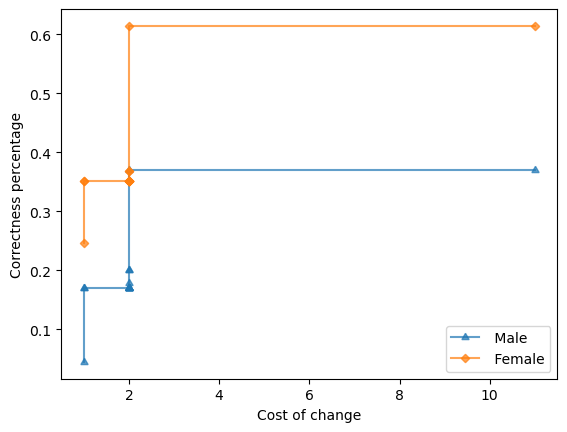

If native-country =  United-States, occupation =  Adm-clerical, race =  White, relationship =  Married:
	Protected Subgroup ' Male', 2.15% covered out of 6761
		Make occupation =  Craft-repair with correctness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Transport-moving with correctness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Protective-serv with correctness 32.86% and counterfactual cost = 1.0.
		Make occupation =  Sales with correctness 32.86% and counterfactual cost = 1.0.
		Make occupation =  Tech-support with correctness 33.57% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 39.29% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 47.86% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty, relationship =  Not-in-family with correctness 47.86% and counterfactual cost = 11.0.
		Make occupation =  Exec-managerial, relationship =  Not-in-family with correctness 47.86% 

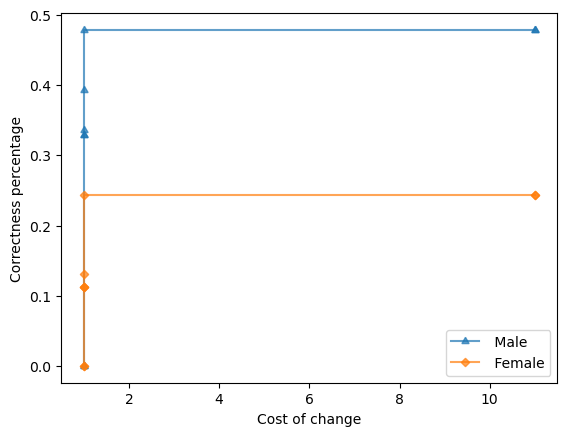

If capital-loss = 0, native-country =  United-States, occupation =  Other-service, race =  White, relationship =  Married:
	Protected Subgroup ' Male', 1.75% covered out of 6761
		Make occupation =  Transport-moving with correctness 5.44% and counterfactual cost = 1.0.
		Make occupation =  Craft-repair with correctness 5.44% and counterfactual cost = 1.0.
		Make occupation =  Adm-clerical with correctness 7.48% and counterfactual cost = 1.0.
		Make occupation =  Protective-serv with correctness 19.73% and counterfactual cost = 1.0.
		Make occupation =  Sales with correctness 19.73% and counterfactual cost = 1.0.
		Make occupation =  Tech-support with correctness 20.41% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 24.49% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 31.29% and counterfactual cost = 1.0.
		Make capital-loss = 1902, occupation =  Prof-specialty with correctness 83.67% and counterfactual cost = 1

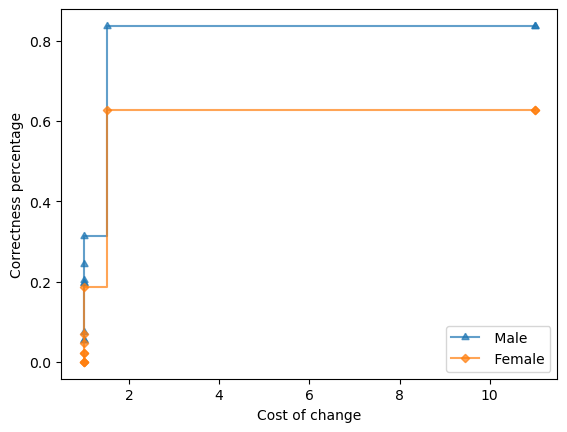

If age = (34.0, 41.0], capital-loss = 0, hours-per-week = FullTime, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.02% covered out of 6761
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 24.69% and counterfactual cost = 11.0.
		Make age = (50.0, 90.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 25.93% and counterfactual cost = 12.0.
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 29.63% and counterfactual cost = 12.0.
		Make hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with correctness 35.80% and counterfactual cost = 12.0.
		Make hours-per-week = BrainDrain, marital-status =  Married-civ-spouse, relationship =  Married with correctness 35.80% and counterfactual cost = 12.0.
		Make age = (50.0, 90.0], hours-per-week = MidTime, marital-status =  Married-civ-spouse, r

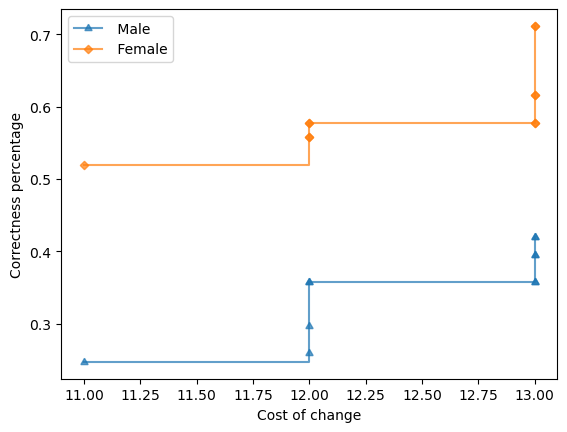

If capital-loss = 0, hours-per-week = FullTime, marital-status =  Never-married, relationship =  Other-relative:
	Protected Subgroup ' Male', 1.37% covered out of 6761
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 1.37% and counterfactual cost = 11.0.
		Make capital-loss = 1887, marital-status =  Married-civ-spouse, relationship =  Married with correctness 17.81% and counterfactual cost = 11.5.
		Make capital-loss = 1902, marital-status =  Married-civ-spouse, relationship =  Married with correctness 17.81% and counterfactual cost = 11.5.
		Make hours-per-week = MidTime, marital-status =  Married-civ-spouse, relationship =  Married with correctness 17.81% and counterfactual cost = 12.0.
		Make hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with correctness 17.81% and counterfactual cost = 12.0.
		Make hours-per-week = BrainDrain, marital-status =  Married-civ-spouse, relationship =  Married with correctnes

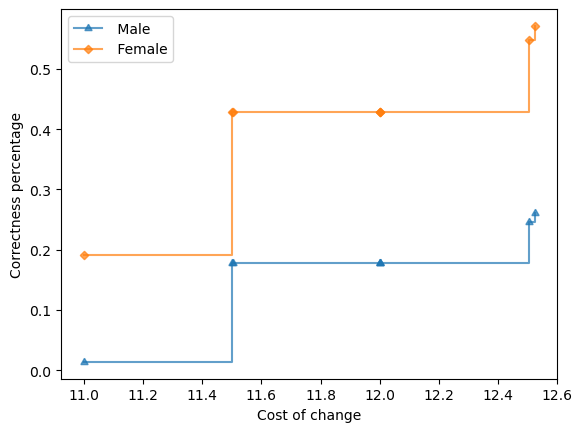

If age = (16.999, 26.0], native-country =  United-States, relationship =  Married:
	Protected Subgroup ' Male', 3.49% covered out of 6761
		Make age = (26.0, 34.0] with correctness 11.23% and counterfactual cost = 1.0.
		Make age = (34.0, 41.0] with correctness 22.46% and counterfactual cost = 1.0.
		Make age = (26.0, 34.0], relationship =  Not-in-family with correctness 22.46% and counterfactual cost = 11.0.
		Make age = (34.0, 41.0], relationship =  Not-in-family with correctness 22.46% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 4.49
	Protected Subgroup ' Female', 1.20% covered out of 4067
		Make age = (26.0, 34.0] with correctness 23.26% and counterfactual cost = 1.0.
		Make age = (34.0, 41.0] with correctness 41.86% and counterfactual cost = 1.0.
		Make age = (26.0, 34.0], relationship =  Not-in-family with correctness 41.86% and counterfactual cost = 11.0.
		Make age = (34.0, 41.0], relationship =  Not-in-family with correctness 41.86% and counterfac

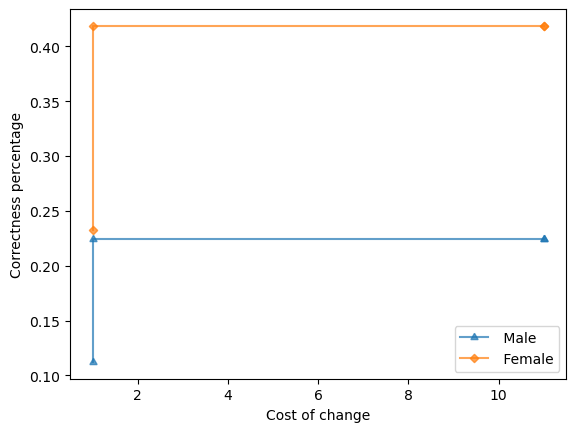

If Workclass =  Private, age = (41.0, 50.0], capital-gain = 0, marital-status =  Never-married, native-country =  United-States, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.00% covered out of 6761
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 37.50% and counterfactual cost = 11.0.
		Make Workclass =  Self-emp-not-inc, marital-status =  Married-civ-spouse, relationship =  Married with correctness 37.50% and counterfactual cost = 12.0.
		Make age = (50.0, 90.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 37.50% and counterfactual cost = 12.0.
		Make Workclass =  Local-gov, marital-status =  Married-civ-spouse, relationship =  Married with correctness 37.50% and counterfactual cost = 12.0.
		Make Workclass =  State-gov, marital-status =  Married-civ-spouse, relationship =  Married with correctness 37.50% and counterfactual cost = 12.0.
		Make Workclass =  Self-emp-inc, marital-status =  Married-c

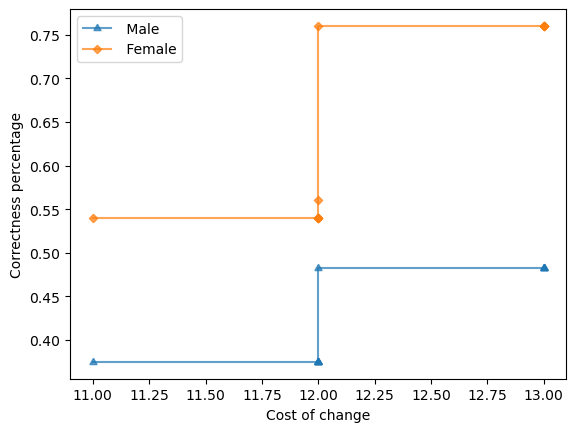

If age = (34.0, 41.0], capital-gain = 0, hours-per-week = FullTime, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.10% covered out of 6761
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 27.06% and counterfactual cost = 11.0.
		Make age = (50.0, 90.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 29.41% and counterfactual cost = 12.0.
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 32.94% and counterfactual cost = 12.0.
		Make hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with correctness 38.82% and counterfactual cost = 12.0.
		Make hours-per-week = BrainDrain, marital-status =  Married-civ-spouse, relationship =  Married with correctness 38.82% and counterfactual cost = 12.0.
		Make age = (50.0, 90.0], hours-per-week = OverTime, marital-status =  Married-civ-spouse, 

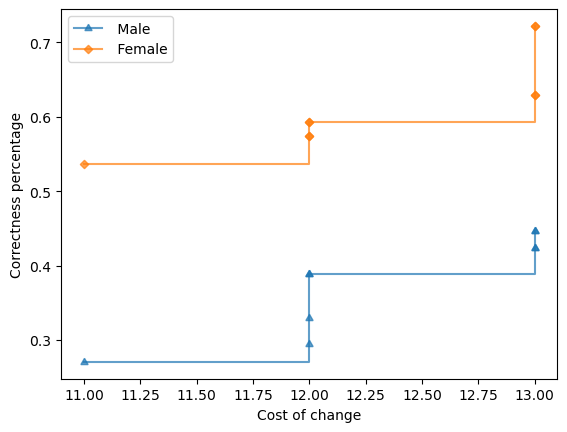

If age = (26.0, 34.0], marital-status =  Divorced, race =  White, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.10% covered out of 6761
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 17.91% and counterfactual cost = 11.0.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 22.39% and counterfactual cost = 12.0.
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 28.36% and counterfactual cost = 12.0.
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, race =  Asian-Pac-Islander, relationship =  Married with correctness 28.36% and counterfactual cost = 13.0.
		Aggregate cost of the above recourses = 9.92
	Protected Subgroup ' Female', 1.59% covered out of 4067
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 24.59% and counterfactual cost = 11.0.
		Make age = (34.0, 41.0], mari

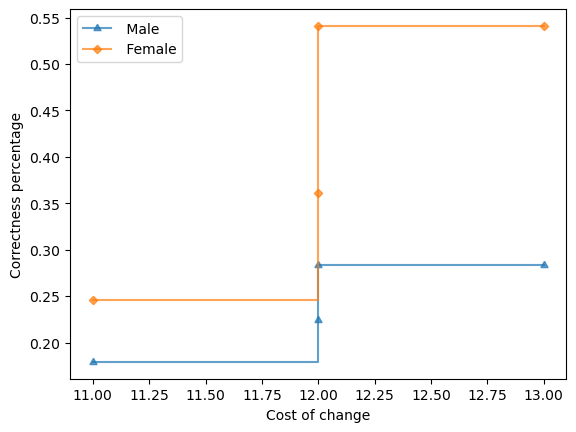

If Workclass =  Private, age = (26.0, 34.0], capital-loss = 0, hours-per-week = FullTime, marital-status =  Never-married, relationship =  Own-child:
	Protected Subgroup ' Male', 1.19% covered out of 6761
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 8.24% and counterfactual cost = 11.0.
		Make hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with correctness 16.47% and counterfactual cost = 12.0.
		Make hours-per-week = BrainDrain, marital-status =  Married-civ-spouse, relationship =  Married with correctness 16.47% and counterfactual cost = 12.0.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 17.65% and counterfactual cost = 12.0.
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 23.53% and counterfactual cost = 12.0.
		Make Workclass =  Local-gov, age = (41.0, 50.0], marital-status =  Marrie

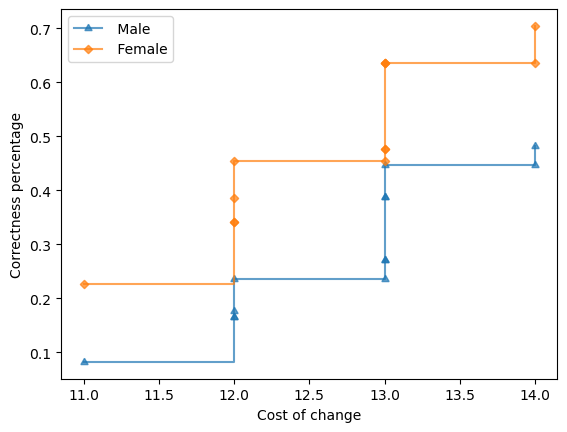

If Workclass =  Private, age = (41.0, 50.0], capital-gain = 0, capital-loss = 0, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.06% covered out of 6761
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 33.90% and counterfactual cost = 11.0.
		Make Workclass =  Self-emp-not-inc, marital-status =  Married-civ-spouse, relationship =  Married with correctness 33.90% and counterfactual cost = 12.0.
		Make age = (50.0, 90.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 33.90% and counterfactual cost = 12.0.
		Make Workclass =  Local-gov, marital-status =  Married-civ-spouse, relationship =  Married with correctness 33.90% and counterfactual cost = 12.0.
		Make Workclass =  State-gov, marital-status =  Married-civ-spouse, relationship =  Married with correctness 33.90% and counterfactual cost = 12.0.
		Make Workclass =  Self-emp-inc, marital-status =  Married-civ-spouse, rela

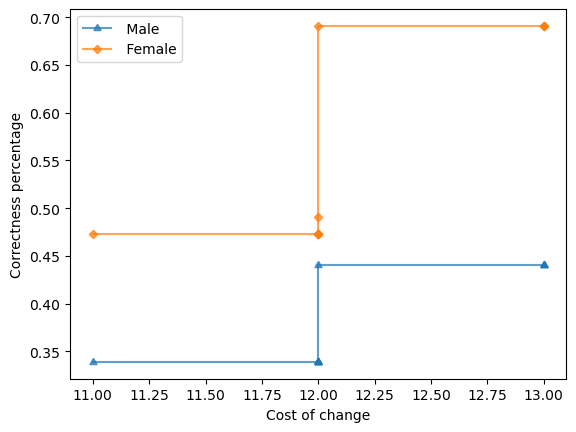

If Workclass =  Private, hours-per-week = OverTime, marital-status =  Never-married, race =  White, relationship =  Not-in-family:
	Protected Subgroup ' Male', 3.16% covered out of 6761
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 32.39% and counterfactual cost = 11.0.
		Make hours-per-week = MidTime, marital-status =  Married-civ-spouse, relationship =  Married with correctness 32.39% and counterfactual cost = 12.0.
		Make Workclass =  Self-emp-not-inc, marital-status =  Married-civ-spouse, relationship =  Married with correctness 32.39% and counterfactual cost = 12.0.
		Make hours-per-week = FullTime, marital-status =  Married-civ-spouse, relationship =  Married with correctness 32.39% and counterfactual cost = 12.0.
		Make Workclass =  Local-gov, marital-status =  Married-civ-spouse, relationship =  Married with correctness 32.39% and counterfactual cost = 12.0.
		Make Workclass =  State-gov, marital-status =  Married-civ-spouse, relationship

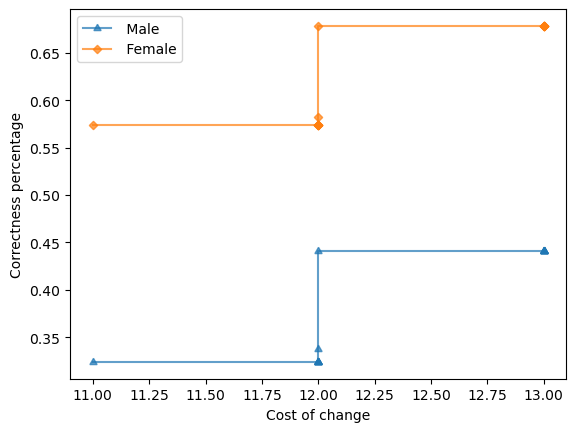

If hours-per-week = OverTime, marital-status =  Never-married, race =  White, relationship =  Not-in-family:
	Protected Subgroup ' Male', 4.00% covered out of 6761
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 37.22% and counterfactual cost = 11.0.
		Make hours-per-week = PartTime, marital-status =  Married-civ-spouse, relationship =  Married with correctness 37.22% and counterfactual cost = 12.0.
		Make hours-per-week = MidTime, marital-status =  Married-civ-spouse, relationship =  Married with correctness 37.22% and counterfactual cost = 12.0.
		Make hours-per-week = FullTime, marital-status =  Married-civ-spouse, relationship =  Married with correctness 37.22% and counterfactual cost = 12.0.
		Make hours-per-week = BrainDrain, marital-status =  Married-civ-spouse, relationship =  Married with correctness 37.22% and counterfactual cost = 12.0.
		Make hours-per-week = FullTime, marital-status =  Married-civ-spouse, race =  Black, relationship = 

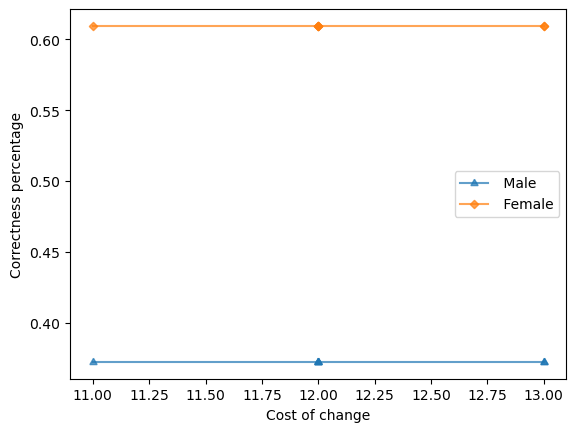

If Workclass =  Private, hours-per-week = FullTime, marital-status =  Never-married, relationship =  Other-relative:
	Protected Subgroup ' Male', 1.19% covered out of 6761
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 1.49% and counterfactual cost = 11.0.
		Make Workclass =  Local-gov, marital-status =  Married-civ-spouse, relationship =  Married with correctness 1.49% and counterfactual cost = 12.0.
		Make Workclass =  State-gov, marital-status =  Married-civ-spouse, relationship =  Married with correctness 1.49% and counterfactual cost = 12.0.
		Make Workclass =  Self-emp-not-inc, marital-status =  Married-civ-spouse, relationship =  Married with correctness 1.49% and counterfactual cost = 12.0.
		Make hours-per-week = MidTime, marital-status =  Married-civ-spouse, relationship =  Married with correctness 1.49% and counterfactual cost = 12.0.
		Make hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with co

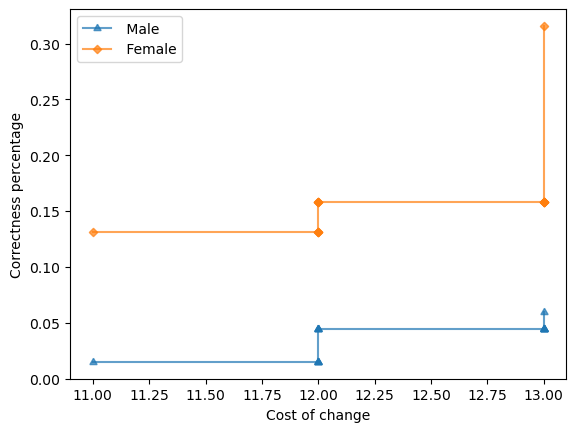

If Workclass =  Private, age = (26.0, 34.0], hours-per-week = OverTime, race =  White, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.51% covered out of 6761
		Make relationship =  Married with correctness 2.52% and counterfactual cost = 10.0.
		Make hours-per-week = FullTime, relationship =  Married with correctness 2.52% and counterfactual cost = 11.0.
		Make hours-per-week = BrainDrain, relationship =  Married with correctness 2.52% and counterfactual cost = 11.0.
		Make age = (34.0, 41.0], relationship =  Married with correctness 6.72% and counterfactual cost = 11.0.
		Make age = (41.0, 50.0], relationship =  Married with correctness 14.29% and counterfactual cost = 11.0.
		Make age = (34.0, 41.0], hours-per-week = FullTime, relationship =  Married with correctness 14.29% and counterfactual cost = 12.0.
		Make Workclass =  Self-emp-not-inc, age = (41.0, 50.0], relationship =  Married with correctness 14.29% and counterfactual cost = 12.0.
		Make age = (41.0, 50.0], h

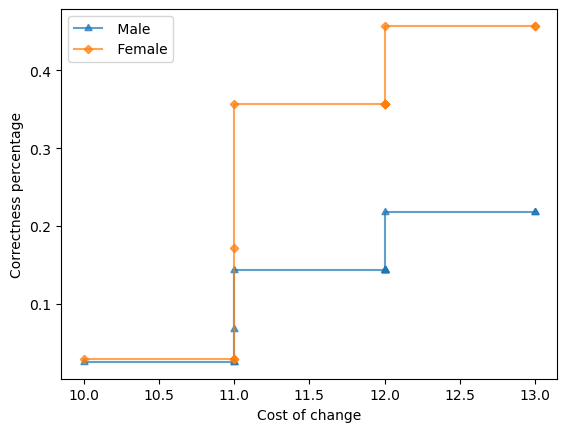

If age = (26.0, 34.0], capital-loss = 0, hours-per-week = FullTime, marital-status =  Never-married, race =  White, relationship =  Not-in-family:
	Protected Subgroup ' Male', 2.27% covered out of 6761
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 25.56% and counterfactual cost = 11.0.
		Make hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with correctness 35.34% and counterfactual cost = 12.0.
		Make hours-per-week = BrainDrain, marital-status =  Married-civ-spouse, relationship =  Married with correctness 35.34% and counterfactual cost = 12.0.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 35.34% and counterfactual cost = 12.0.
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 43.61% and counterfactual cost = 12.0.
		Make age = (34.0, 41.0], hours-per-week = OverTime, marital-status =  Marri

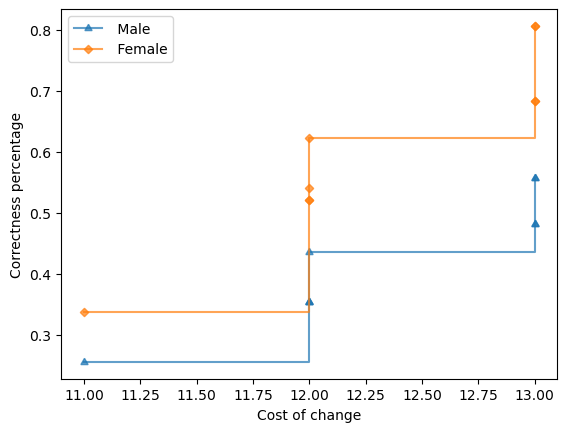

If Workclass =  Private, age = (26.0, 34.0], capital-gain = 0, capital-loss = 0, hours-per-week = FullTime, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Male', 2.15% covered out of 6761
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 22.56% and counterfactual cost = 11.0.
		Make hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with correctness 33.08% and counterfactual cost = 12.0.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 33.83% and counterfactual cost = 12.0.
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 40.60% and counterfactual cost = 12.0.
		Make age = (34.0, 41.0], hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with correctness 47.37% and counterfactual cost = 13.0.
		Make age = (34.0, 41.0], hours-p

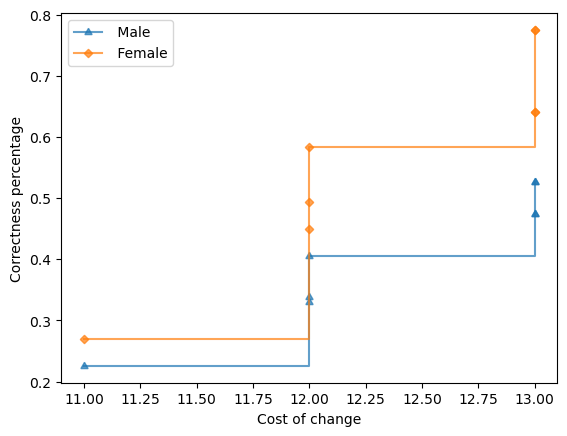

If Workclass =  Private, age = (26.0, 34.0], capital-gain = 0, hours-per-week = OverTime, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.60% covered out of 6761
		Make relationship =  Married with correctness 1.54% and counterfactual cost = 10.0.
		Make hours-per-week = FullTime, relationship =  Married with correctness 1.54% and counterfactual cost = 11.0.
		Make hours-per-week = BrainDrain, relationship =  Married with correctness 1.54% and counterfactual cost = 11.0.
		Make age = (34.0, 41.0], relationship =  Married with correctness 4.62% and counterfactual cost = 11.0.
		Make age = (41.0, 50.0], relationship =  Married with correctness 11.54% and counterfactual cost = 11.0.
		Make age = (34.0, 41.0], hours-per-week = FullTime, relationship =  Married with correctness 11.54% and counterfactual cost = 12.0.
		Make Workclass =  Self-emp-not-inc, age = (41.0, 50.0], relationship =  Married with correctness 11.54% and counterfactual cost = 12.0.
		Make age = (41.0, 50.0]

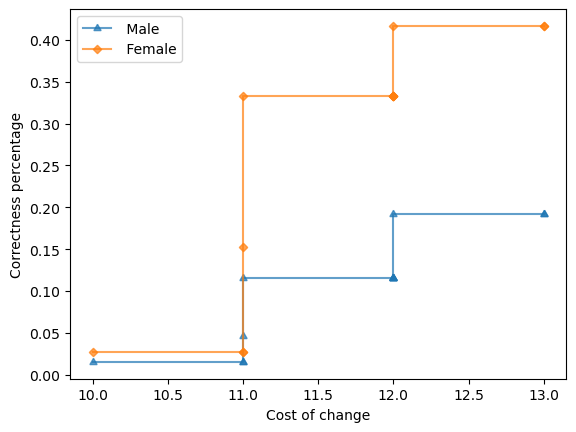

In [15]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="fairness-of-mean-recourse",
    sort_strategy="generic-sorting",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        # "remove-fair-rules",
        # "keep-only-min-change"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric=False
)

## Fairness of Coverage

If Workclass =  Private, age = (26.0, 34.0], native-country =  United-States, occupation =  Machine-op-inspct:
	Protected Subgroup ' Male', 1.91% covered out of 6761
		Make occupation =  Sales with correctness 4.48% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 6.72% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 6.72% and counterfactual cost = 1.0.
		Make age = (34.0, 41.0], occupation =  Sales with correctness 8.21% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Craft-repair with correctness 8.21% and counterfactual cost = 2.0.
		Make age = (34.0, 41.0], occupation =  Craft-repair with correctness 8.21% and counterfactual cost = 2.0.
		Make age = (34.0, 41.0], occupation =  Prof-specialty with correctness 22.39% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Sales with correctness 22.39% and counterfactual cost = 2.0.
		Make age = (34.0, 41.0], occupation =  E

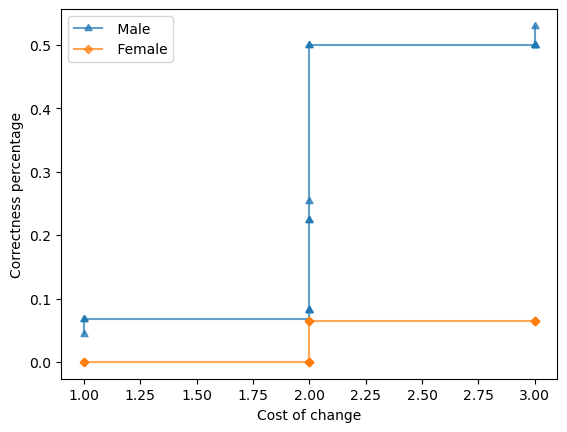

If Workclass =  Private, age = (50.0, 90.0], capital-loss = 0, occupation =  Sales:
	Protected Subgroup ' Male', 1.09% covered out of 6761
		Make occupation =  Prof-specialty with correctness 35.94% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 37.50% and counterfactual cost = 1.0.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with correctness 48.44% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 0.48
	Protected Subgroup ' Female', 1.61% covered out of 4067
		Make occupation =  Exec-managerial with correctness 4.76% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 4.76% and counterfactual cost = 1.0.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with correctness 6.35% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 0.06
	Bias against  Female. Unfairness measure = 0.421.
	Cumulative correctness plot for the above recourses:


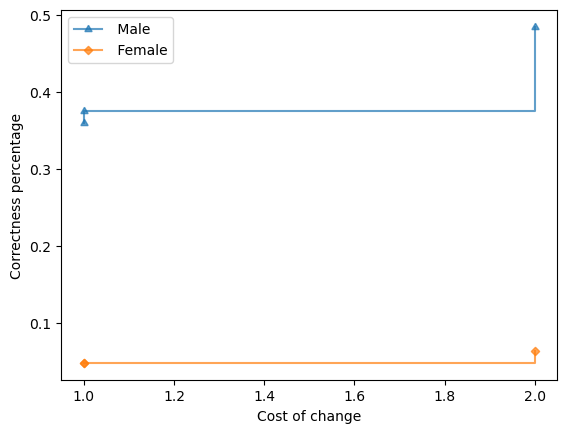

If age = (34.0, 41.0], capital-gain = 0, capital-loss = 0, occupation =  Adm-clerical:
	Protected Subgroup ' Male', 1.07% covered out of 6761
		Make age = (41.0, 50.0] with correctness 11.69% and counterfactual cost = 1.0.
		Make occupation =  Sales with correctness 11.69% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 29.87% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 38.96% and counterfactual cost = 1.0.
		Make age = (41.0, 50.0], occupation =  Craft-repair with correctness 38.96% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Sales with correctness 38.96% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Sales with correctness 38.96% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Prof-specialty with correctness 38.96% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Exec-managerial with correctness 40.26% and cou

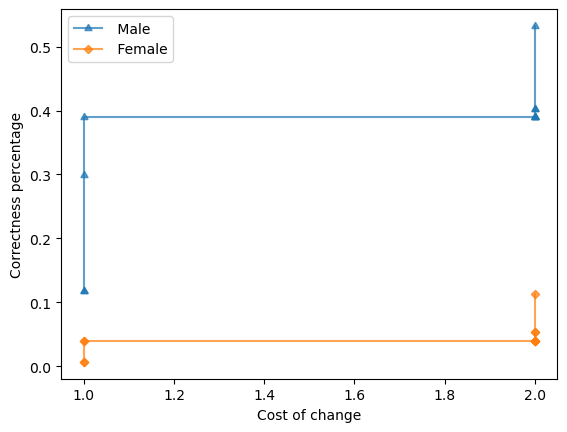

If age = (26.0, 34.0], native-country =  United-States, occupation =  Machine-op-inspct:
	Protected Subgroup ' Male', 2.03% covered out of 6761
		Make occupation =  Sales with correctness 4.23% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 6.34% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 7.04% and counterfactual cost = 1.0.
		Make age = (34.0, 41.0], occupation =  Craft-repair with correctness 7.04% and counterfactual cost = 2.0.
		Make age = (34.0, 41.0], occupation =  Sales with correctness 8.45% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Craft-repair with correctness 8.45% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Adm-clerical with correctness 9.15% and counterfactual cost = 2.0.
		Make age = (34.0, 41.0], occupation =  Prof-specialty with correctness 21.83% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Sales with correc

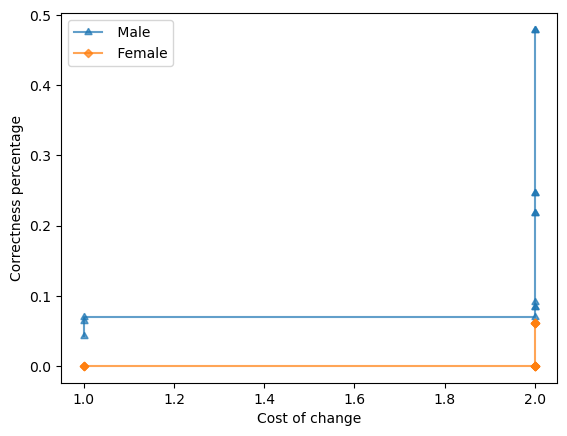

If Workclass =  Private, capital-loss = 0, education-num = 9, occupation =  Craft-repair:
	Protected Subgroup ' Male', 8.42% covered out of 6761
		Make occupation =  Exec-managerial with correctness 20.03% and counterfactual cost = 1.0.
		Make education-num = 10, occupation =  Sales with correctness 20.03% and counterfactual cost = 2.33.
		Make education-num = 10, occupation =  Prof-specialty with correctness 28.05% and counterfactual cost = 2.33.
		Make education-num = 10, occupation =  Exec-managerial with correctness 37.46% and counterfactual cost = 2.33.
		Make Workclass =  Self-emp-inc, education-num = 10, occupation =  Exec-managerial with correctness 44.43% and counterfactual cost = 3.33.
		Make education-num = 11, occupation =  Exec-managerial with correctness 45.30% and counterfactual cost = 3.67.
		Aggregate cost of the above recourses = 0.45
	Protected Subgroup ' Female', 1.08% covered out of 4067
		Make occupation =  Exec-managerial with correctness 0.00% and counterfactual

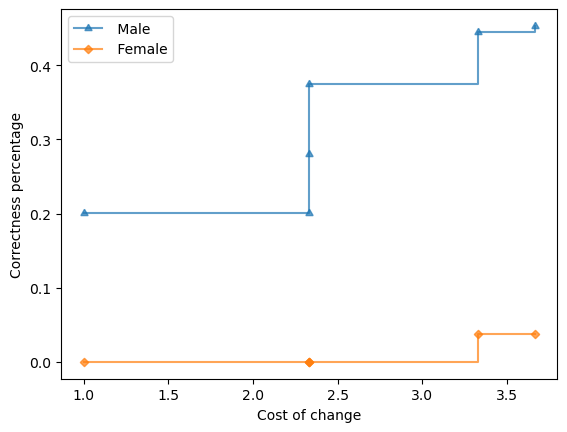

If Workclass =  Private, age = (41.0, 50.0], capital-gain = 0, occupation =  Machine-op-inspct:
	Protected Subgroup ' Male', 1.61% covered out of 6761
		Make occupation =  Craft-repair with correctness 6.19% and counterfactual cost = 1.0.
		Make occupation =  Sales with correctness 20.35% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 29.20% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 43.36% and counterfactual cost = 1.0.
		Make age = (50.0, 90.0], occupation =  Sales with correctness 43.36% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Exec-managerial with correctness 43.36% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Prof-specialty with correctness 43.36% and counterfactual cost = 2.0.
		Make Workclass =  Local-gov, occupation =  Prof-specialty with correctness 43.36% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc, age = (50.0, 90.0], oc

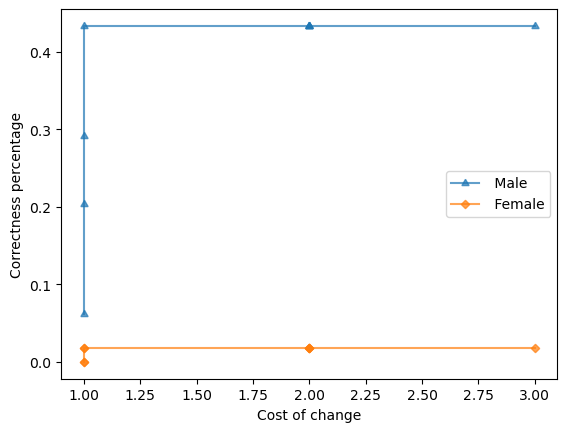

If Workclass =  Private, education-num = 9, native-country =  United-States, occupation =  Craft-repair:
	Protected Subgroup ' Male', 8.11% covered out of 6761
		Make occupation =  Sales with correctness 3.44% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 20.29% and counterfactual cost = 1.0.
		Make education-num = 10, occupation =  Sales with correctness 20.29% and counterfactual cost = 2.33.
		Make education-num = 10, occupation =  Prof-specialty with correctness 28.62% and counterfactual cost = 2.33.
		Make education-num = 10, occupation =  Exec-managerial with correctness 38.22% and counterfactual cost = 2.33.
		Make Workclass =  Self-emp-inc, education-num = 10, occupation =  Exec-managerial with correctness 44.57% and counterfactual cost = 3.33.
		Make education-num = 11, occupation =  Exec-managerial with correctness 45.29% and counterfactual cost = 3.67.
		Aggregate cost of the above recourses = 0.45
	Protected Subgroup ' Female', 1.03% co

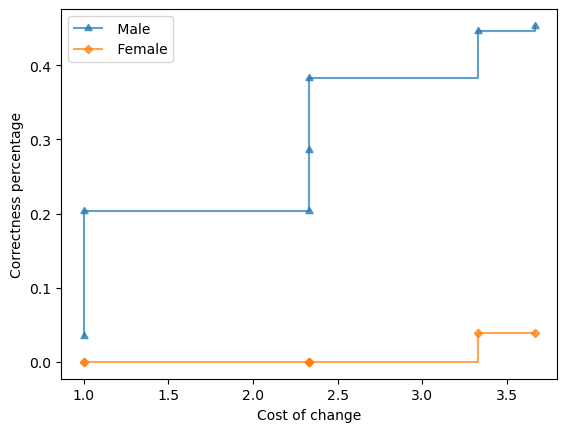

If capital-loss = 0, native-country =  United-States, occupation =  Machine-op-inspct:
	Protected Subgroup ' Male', 8.08% covered out of 6761
		Make occupation =  Craft-repair with correctness 2.96% and counterfactual cost = 1.0.
		Make occupation =  Transport-moving with correctness 2.96% and counterfactual cost = 1.0.
		Make occupation =  Adm-clerical with correctness 4.07% and counterfactual cost = 1.0.
		Make occupation =  Protective-serv with correctness 11.30% and counterfactual cost = 1.0.
		Make occupation =  Sales with correctness 11.30% and counterfactual cost = 1.0.
		Make occupation =  Tech-support with correctness 11.48% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 14.26% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 18.52% and counterfactual cost = 1.0.
		Make capital-loss = 1902, occupation =  Prof-specialty with correctness 47.04% and counterfactual cost = 1.5.
		Aggregate cost of the above re

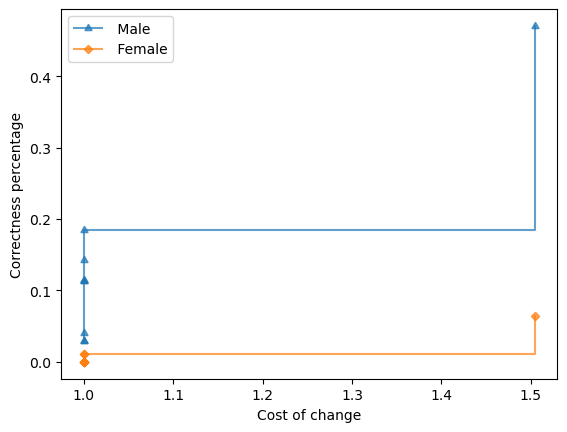

If capital-loss = 0, education-num = 11, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 3.58% covered out of 6761
		Make education-num = 12 with correctness 13.21% and counterfactual cost = 1.33.
		Make education-num = 13 with correctness 24.53% and counterfactual cost = 2.67.
		Make capital-loss = 1902, education-num = 13 with correctness 57.08% and counterfactual cost = 3.17.
		Aggregate cost of the above recourses = 0.57
	Protected Subgroup ' Female', 3.39% covered out of 4067
		Make education-num = 12 with correctness 1.67% and counterfactual cost = 1.33.
		Make education-num = 13 with correctness 5.83% and counterfactual cost = 2.67.
		Make capital-loss = 1902, education-num = 13 with correctness 16.67% and counterfactual cost = 3.17.
		Aggregate cost of the above recourses = 0.17
	Bias against  Female. Unfairness measure = 0.404.
	Cumulative correctness plot for the above recourses:


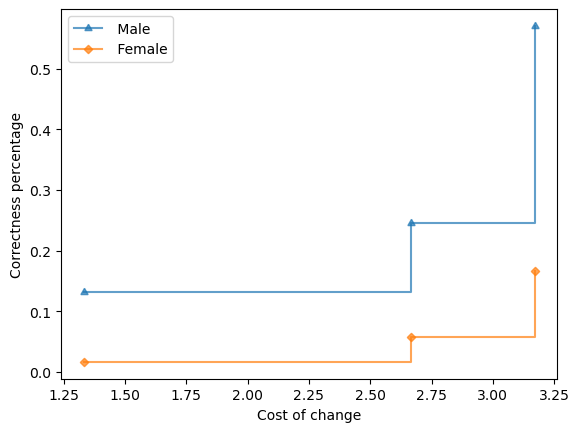

If Workclass =  Private, age = (26.0, 34.0], capital-loss = 0, occupation =  Machine-op-inspct:
	Protected Subgroup ' Male', 2.10% covered out of 6761
		Make occupation =  Sales with correctness 2.63% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 3.29% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 3.95% and counterfactual cost = 1.0.
		Make age = (34.0, 41.0], occupation =  Sales with correctness 5.26% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Craft-repair with correctness 5.26% and counterfactual cost = 2.0.
		Make age = (34.0, 41.0], occupation =  Craft-repair with correctness 5.26% and counterfactual cost = 2.0.
		Make age = (34.0, 41.0], occupation =  Prof-specialty with correctness 17.76% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Sales with correctness 17.76% and counterfactual cost = 2.0.
		Make age = (34.0, 41.0], occupation =  Exec-managerial 

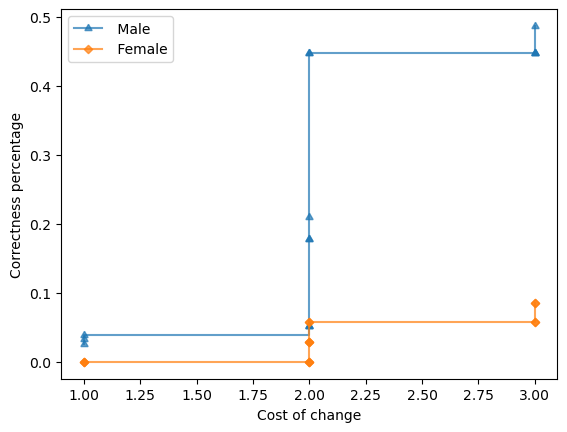

If age = (41.0, 50.0], occupation =  Machine-op-inspct:
	Protected Subgroup ' Male', 1.70% covered out of 6761
		Make occupation =  Craft-repair with correctness 7.20% and counterfactual cost = 1.0.
		Make occupation =  Adm-clerical with correctness 9.60% and counterfactual cost = 1.0.
		Make occupation =  Sales with correctness 21.60% and counterfactual cost = 1.0.
		Make occupation =  Tech-support with correctness 29.60% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 30.40% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 43.20% and counterfactual cost = 1.0.
		Make age = (50.0, 90.0], occupation =  Craft-repair with correctness 43.20% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Adm-clerical with correctness 43.20% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Sales with correctness 43.20% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =

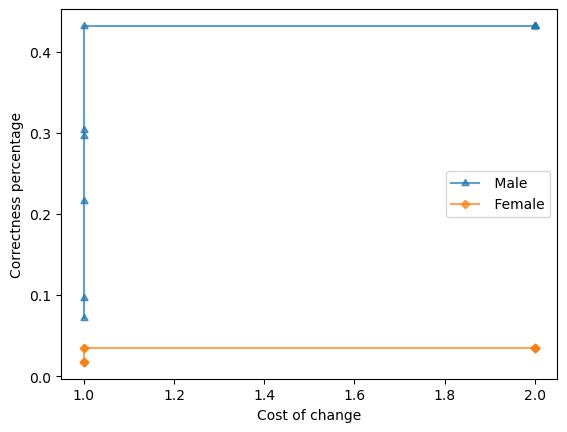

If capital-loss = 0, native-country =  United-States, occupation =  Craft-repair, race =  White:
	Protected Subgroup ' Male', 18.51% covered out of 6761
		Make occupation =  Transport-moving with correctness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Adm-clerical with correctness 1.27% and counterfactual cost = 1.0.
		Make occupation =  Protective-serv with correctness 10.43% and counterfactual cost = 1.0.
		Make occupation =  Sales with correctness 10.43% and counterfactual cost = 1.0.
		Make occupation =  Tech-support with correctness 10.99% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 14.01% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 20.54% and counterfactual cost = 1.0.
		Make capital-loss = 1902, occupation =  Prof-specialty with correctness 52.07% and counterfactual cost = 1.5.
		Aggregate cost of the above recourses = 0.52
	Protected Subgroup ' Female', 1.59% covered out of 4067
		Mak

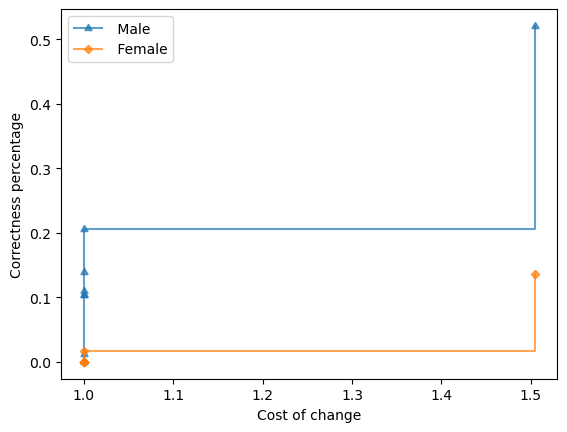

If Workclass =  Private, capital-gain = 0, capital-loss = 0, education-num = 11, hours-per-week = FullTime, race =  White:
	Protected Subgroup ' Male', 1.76% covered out of 6761
		Make education-num = 13 with correctness 26.85% and counterfactual cost = 2.67.
		Make education-num = 13, hours-per-week = OverTime with correctness 44.44% and counterfactual cost = 3.67.
		Make education-num = 13, hours-per-week = BrainDrain with correctness 44.44% and counterfactual cost = 3.67.
		Aggregate cost of the above recourses = 0.44
	Protected Subgroup ' Female', 1.52% covered out of 4067
		Make education-num = 13 with correctness 6.12% and counterfactual cost = 2.67.
		Make education-num = 13, hours-per-week = OverTime with correctness 6.12% and counterfactual cost = 3.67.
		Make education-num = 13, hours-per-week = BrainDrain with correctness 6.12% and counterfactual cost = 3.67.
		Aggregate cost of the above recourses = 0.06
	Bias against  Female. Unfairness measure = 0.383.
	Cumulative correct

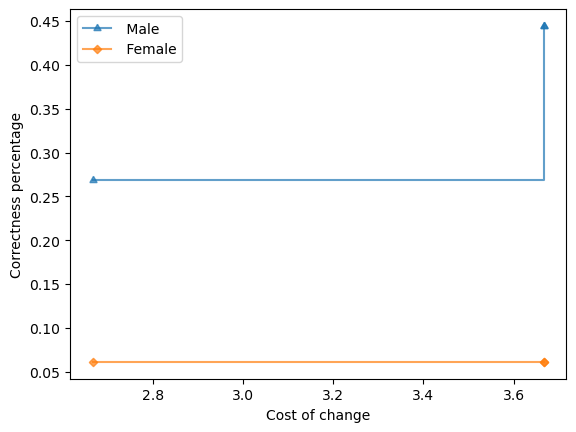

If capital-gain = 0, capital-loss = 0, education-num = 11, hours-per-week = FullTime, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 2.02% covered out of 6761
		Make education-num = 12 with correctness 12.70% and counterfactual cost = 1.33.
		Make education-num = 12, hours-per-week = OverTime with correctness 30.95% and counterfactual cost = 2.33.
		Make education-num = 13 with correctness 30.95% and counterfactual cost = 2.67.
		Make education-num = 13, hours-per-week = OverTime with correctness 43.65% and counterfactual cost = 3.67.
		Make education-num = 13, hours-per-week = BrainDrain with correctness 43.65% and counterfactual cost = 3.67.
		Aggregate cost of the above recourses = 0.44
	Protected Subgroup ' Female', 1.61% covered out of 4067
		Make education-num = 12 with correctness 0.00% and counterfactual cost = 1.33.
		Make education-num = 12, hours-per-week = OverTime with correctness 5.36% and counterfactual cost = 2.33.
		Make education-num = 13

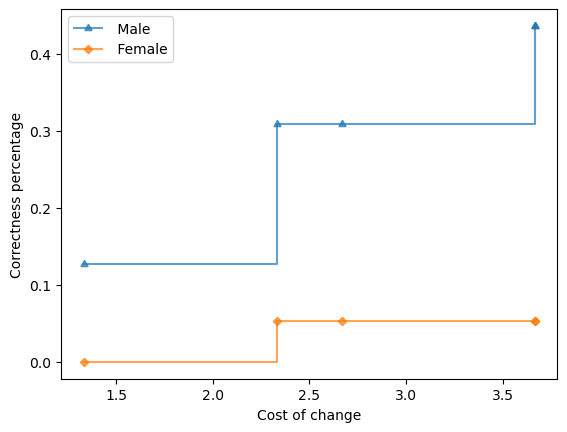

If capital-gain = 0, education-num = 9, native-country =  United-States, occupation =  Sales, race =  White:
	Protected Subgroup ' Male', 3.08% covered out of 6761
		Make occupation =  Exec-managerial with correctness 21.76% and counterfactual cost = 1.0.
		Make education-num = 10 with correctness 21.76% and counterfactual cost = 1.33.
		Make education-num = 10, occupation =  Prof-specialty with correctness 25.93% and counterfactual cost = 2.33.
		Make education-num = 10, occupation =  Exec-managerial with correctness 32.41% and counterfactual cost = 2.33.
		Make education-num = 11, occupation =  Exec-managerial with correctness 43.52% and counterfactual cost = 3.67.
		Aggregate cost of the above recourses = 0.44
	Protected Subgroup ' Female', 3.61% covered out of 4067
		Make occupation =  Exec-managerial with correctness 1.33% and counterfactual cost = 1.0.
		Make education-num = 10 with correctness 1.33% and counterfactual cost = 1.33.
		Make education-num = 10, occupation =  Exec-ma

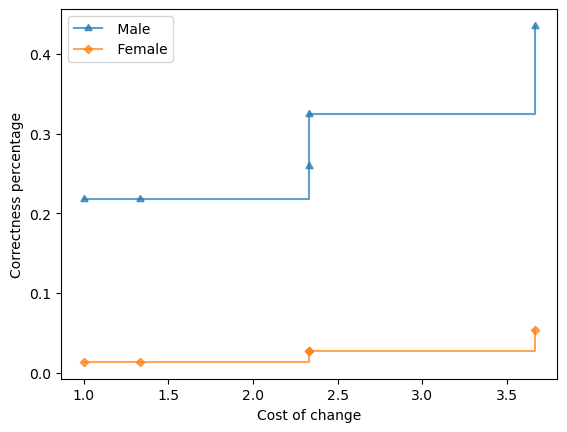

If Workclass =  Private, age = (34.0, 41.0], native-country =  United-States, occupation =  Machine-op-inspct:
	Protected Subgroup ' Male', 1.76% covered out of 6761
		Make occupation =  Craft-repair with correctness 5.05% and counterfactual cost = 1.0.
		Make occupation =  Sales with correctness 9.09% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 23.23% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 28.28% and counterfactual cost = 1.0.
		Make age = (41.0, 50.0], occupation =  Craft-repair with correctness 28.28% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Sales with correctness 28.28% and counterfactual cost = 2.0.
		Make Workclass =  Local-gov, occupation =  Prof-specialty with correctness 28.28% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Sales with correctness 28.28% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Exec-manageri

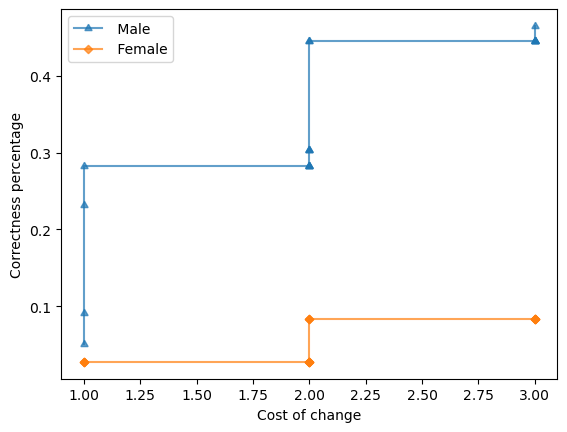

In [16]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="total-correctness",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        # "remove-fair-rules",
        # "keep-only-min-change"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric= True
)

## Fairness of Recourse at Coverage Level 

If education-num = 13, marital-status =  Never-married, occupation =  Exec-managerial:
	Protected Subgroup ' Male', 1.07% covered out of 6761
		Make education-num = 14, marital-status =  Married-civ-spouse with correctness 36.11% and counterfactual cost = 2.33.
		Aggregate cost of the above recourses = 2.33
	Protected Subgroup ' Female', 1.59% covered out of 4067
		Make education-num = 15, marital-status =  Married-civ-spouse, occupation =  Prof-specialty with correctness 35.29% and counterfactual cost = 4.67.
		Aggregate cost of the above recourses = 4.67
	Bias against  Female. Unfairness measure = 2.333.
	Cumulative correctness plot for the above recourses:


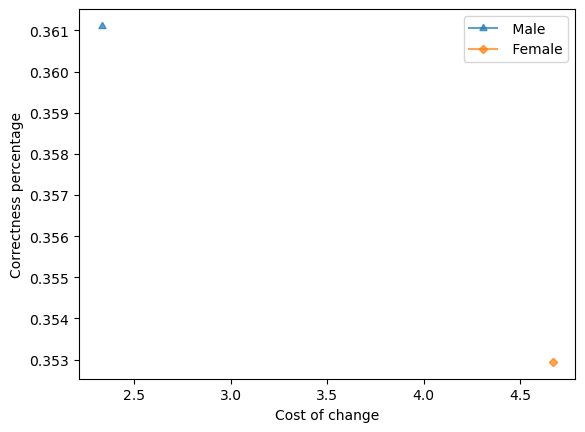

If education-num = 13, occupation =  Exec-managerial, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.06% covered out of 6761
		Make education-num = 15, occupation =  Prof-specialty, relationship =  Married with correctness 37.84% and counterfactual cost = 13.67.
		Aggregate cost of the above recourses = 13.67
	Protected Subgroup ' Female', 1.59% covered out of 4067
		Make education-num = 14, relationship =  Married with correctness 31.34% and counterfactual cost = 11.33.
		Aggregate cost of the above recourses = 11.33
	Bias against  Male. Unfairness measure = 2.333.
	Cumulative correctness plot for the above recourses:


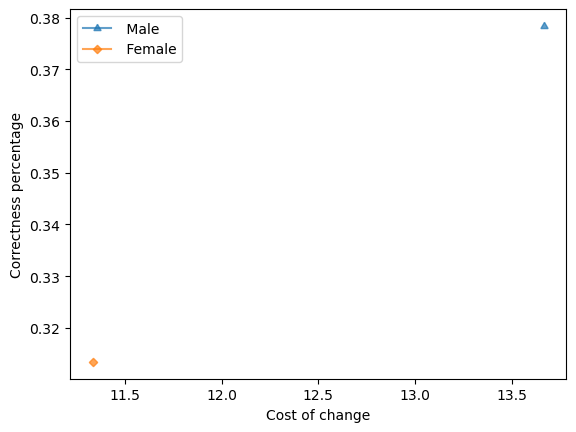

If Workclass =  Private, education-num = 10, marital-status =  Married-civ-spouse:
	Protected Subgroup ' Male', 7.21% covered out of 6761
		Make Workclass =  Federal-gov with correctness 32.84% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup ' Female', 1.66% covered out of 4067
		Make education-num = 12 with correctness 30.00% and counterfactual cost = 2.67.
		Aggregate cost of the above recourses = 2.67
	Bias against  Female. Unfairness measure = 1.667.
	Cumulative correctness plot for the above recourses:


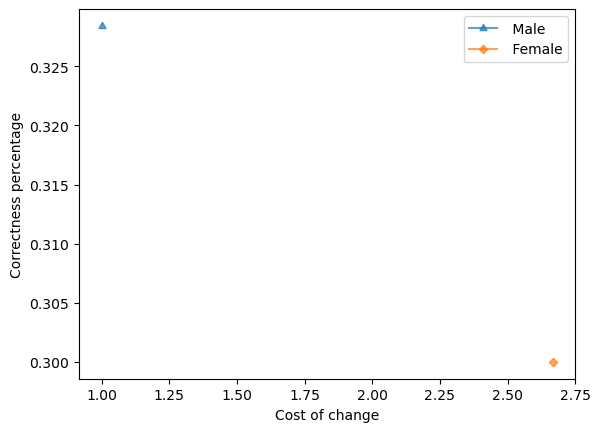

If Workclass =  Private, education-num = 10, relationship =  Married:
	Protected Subgroup ' Male', 7.15% covered out of 6761
		Make Workclass =  Federal-gov with correctness 33.05% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup ' Female', 1.59% covered out of 4067
		Make education-num = 12 with correctness 32.31% and counterfactual cost = 2.67.
		Aggregate cost of the above recourses = 2.67
	Bias against  Female. Unfairness measure = 1.667.
	Cumulative correctness plot for the above recourses:


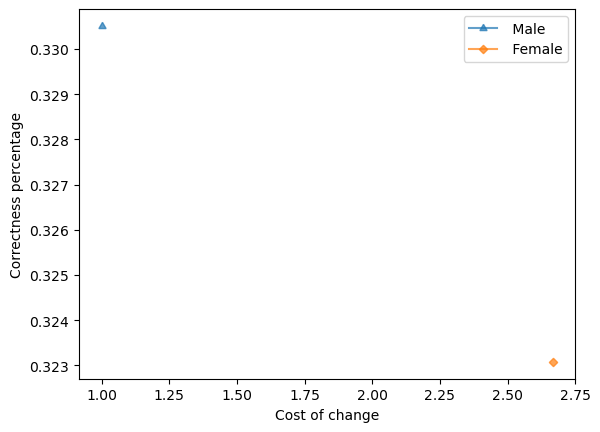

If Workclass =  Private, education-num = 13, hours-per-week = OverTime, marital-status =  Never-married:
	Protected Subgroup ' Male', 1.13% covered out of 6761
		Make education-num = 15, marital-status =  Married-civ-spouse with correctness 42.31% and counterfactual cost = 3.67.
		Aggregate cost of the above recourses = 3.67
	Protected Subgroup ' Female', 1.13% covered out of 4067
		Make Workclass =  Self-emp-inc, marital-status =  Married-civ-spouse with correctness 35.59% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 2.00
	Bias against  Male. Unfairness measure = 1.667.
	Cumulative correctness plot for the above recourses:


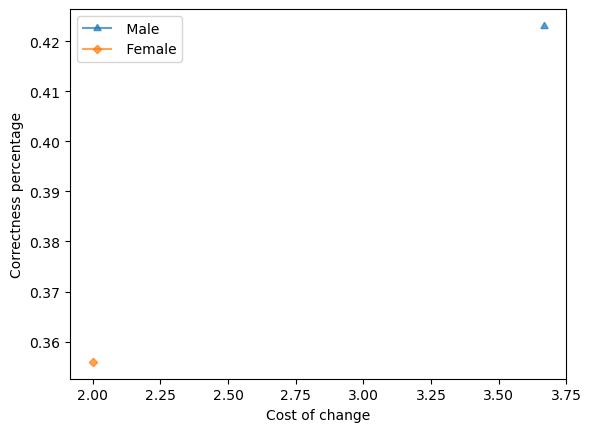

If Workclass =  Private, education-num = 13, marital-status =  Never-married, occupation =  Prof-specialty:
	Protected Subgroup ' Male', 1.04% covered out of 6761
		Make Workclass =  Self-emp-inc, education-num = 15, marital-status =  Married-civ-spouse with correctness 43.48% and counterfactual cost = 4.67.
		Aggregate cost of the above recourses = 4.67
	Protected Subgroup ' Female', 1.88% covered out of 4067
		Make Workclass =  Self-emp-inc, marital-status =  Married-civ-spouse, occupation =  Exec-managerial with correctness 32.31% and counterfactual cost = 3.0.
		Aggregate cost of the above recourses = 3.00
	Bias against  Male. Unfairness measure = 1.667.
	Cumulative correctness plot for the above recourses:


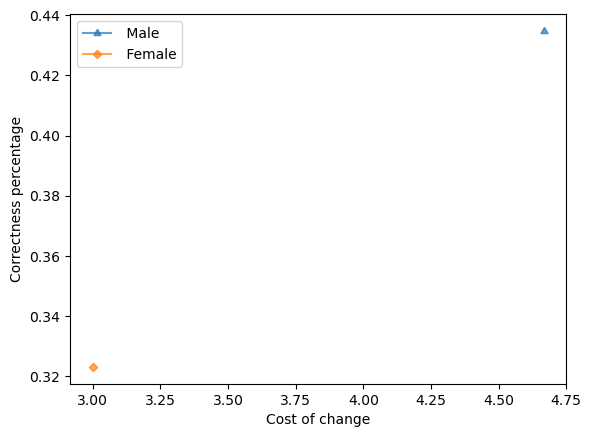

If age = (26.0, 34.0], capital-gain = 0, education-num = 13, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.60% covered out of 6761
		Make age = (41.0, 50.0], education-num = 14, relationship =  Married with correctness 33.02% and counterfactual cost = 12.33.
		Aggregate cost of the above recourses = 12.33
	Protected Subgroup ' Female', 2.31% covered out of 4067
		Make age = (41.0, 50.0], education-num = 15, relationship =  Married with correctness 52.43% and counterfactual cost = 13.67.
		Aggregate cost of the above recourses = 13.67
	Bias against  Female. Unfairness measure = 1.333.
	Cumulative correctness plot for the above recourses:


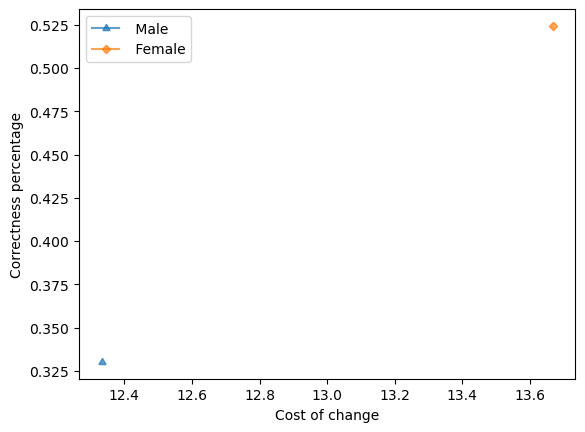

If education-num = 10, hours-per-week = FullTime, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.58% covered out of 6761
		Make education-num = 12, hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with correctness 39.02% and counterfactual cost = 14.67.
		Aggregate cost of the above recourses = 14.67
	Protected Subgroup ' Female', 2.02% covered out of 4067
		Make education-num = 11, hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with correctness 35.90% and counterfactual cost = 13.33.
		Aggregate cost of the above recourses = 13.33
	Bias against  Male. Unfairness measure = 1.333.
	Cumulative correctness plot for the above recourses:


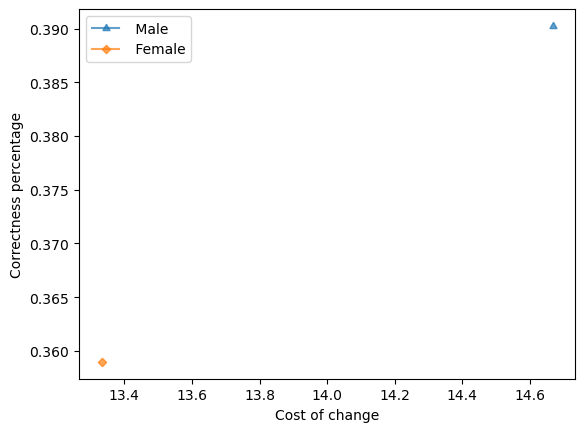

If age = (26.0, 34.0], capital-loss = 0, education-num = 13, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.57% covered out of 6761
		Make age = (41.0, 50.0], education-num = 14, relationship =  Married with correctness 30.39% and counterfactual cost = 12.33.
		Aggregate cost of the above recourses = 12.33
	Protected Subgroup ' Female', 2.31% covered out of 4067
		Make age = (41.0, 50.0], education-num = 15, relationship =  Married with correctness 49.49% and counterfactual cost = 13.67.
		Aggregate cost of the above recourses = 13.67
	Bias against  Female. Unfairness measure = 1.333.
	Cumulative correctness plot for the above recourses:


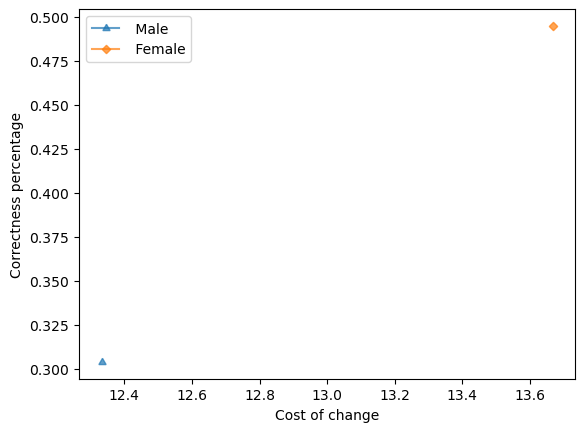

If age = (26.0, 34.0], education-num = 13, native-country =  United-States, race =  White, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.43% covered out of 6761
		Make age = (41.0, 50.0], education-num = 14, relationship =  Married with correctness 35.16% and counterfactual cost = 12.33.
		Aggregate cost of the above recourses = 12.33
	Protected Subgroup ' Female', 2.09% covered out of 4067
		Make age = (41.0, 50.0], education-num = 15, relationship =  Married with correctness 55.43% and counterfactual cost = 13.67.
		Aggregate cost of the above recourses = 13.67
	Bias against  Female. Unfairness measure = 1.333.
	Cumulative correctness plot for the above recourses:


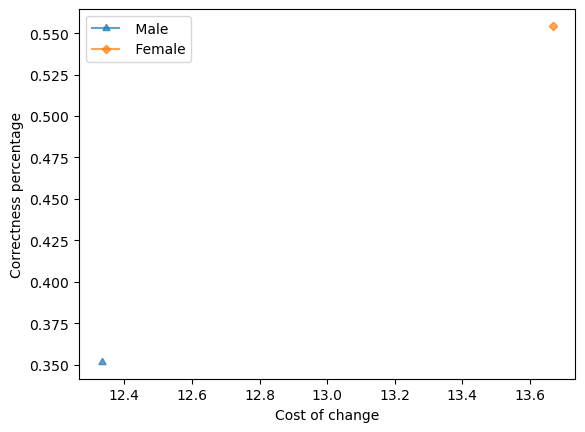

If education-num = 9, hours-per-week = FullTime, marital-status =  Divorced, native-country =  United-States, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.43% covered out of 6761
		Make education-num = 11, hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with correctness 47.13% and counterfactual cost = 14.67.
		Aggregate cost of the above recourses = 14.67
	Protected Subgroup ' Female', 2.19% covered out of 4067
		Make education-num = 10, hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with correctness 31.03% and counterfactual cost = 13.33.
		Make education-num = 10, hours-per-week = BrainDrain, marital-status =  Married-civ-spouse, relationship =  Married with correctness 31.03% and counterfactual cost = 13.33.
		Aggregate cost of the above recourses = 13.33
	Bias against  Male. Unfairness measure = 1.333.
	Cumulative correctness plot for the above recourses:


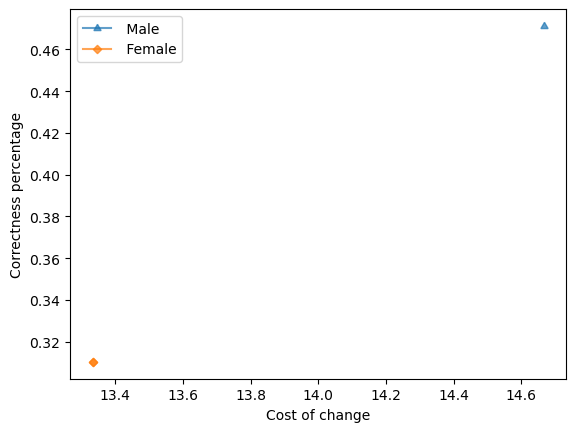

In [17]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="min-above-corr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "remove-below-thr",
        "keep-only-min-change",
        
    ],
    cor_threshold = 0.3,
    params=params
)

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric=False
)

## Fairness of Coverage at Recourse Budget

If Workclass =  Private, age = (26.0, 34.0], native-country =  United-States, occupation =  Machine-op-inspct:
	Protected Subgroup ' Male', 1.91% covered out of 6761
		Make occupation =  Sales with correctness 4.48% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 6.72% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 6.72% and counterfactual cost = 1.0.
		Make age = (34.0, 41.0], occupation =  Sales with correctness 8.21% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Craft-repair with correctness 8.21% and counterfactual cost = 2.0.
		Make age = (34.0, 41.0], occupation =  Craft-repair with correctness 8.21% and counterfactual cost = 2.0.
		Make age = (34.0, 41.0], occupation =  Prof-specialty with correctness 22.39% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Sales with correctness 22.39% and counterfactual cost = 2.0.
		Make age = (34.0, 41.0], occupation =  E

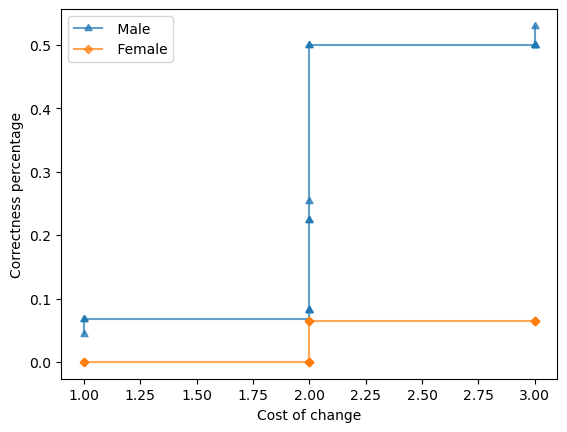

If Workclass =  Private, age = (50.0, 90.0], capital-loss = 0, occupation =  Sales:
	Protected Subgroup ' Male', 1.09% covered out of 6761
		Make occupation =  Prof-specialty with correctness 35.94% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 37.50% and counterfactual cost = 1.0.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with correctness 48.44% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 0.48
	Protected Subgroup ' Female', 1.61% covered out of 4067
		Make occupation =  Exec-managerial with correctness 4.76% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 4.76% and counterfactual cost = 1.0.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with correctness 6.35% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 0.06
	Bias against  Female. Unfairness measure = 0.421.
	Cumulative correctness plot for the above recourses:


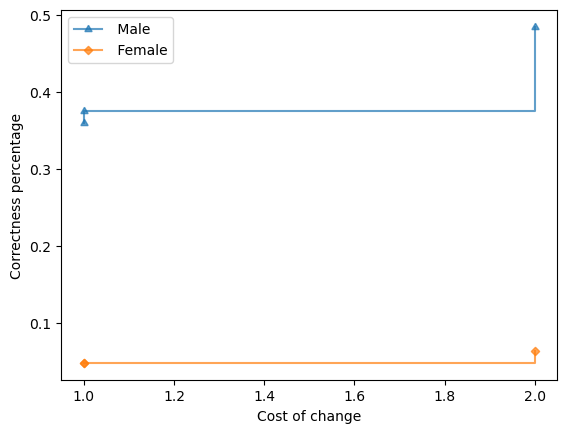

If age = (34.0, 41.0], capital-gain = 0, capital-loss = 0, occupation =  Adm-clerical:
	Protected Subgroup ' Male', 1.07% covered out of 6761
		Make age = (41.0, 50.0] with correctness 11.69% and counterfactual cost = 1.0.
		Make occupation =  Sales with correctness 11.69% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 29.87% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 38.96% and counterfactual cost = 1.0.
		Make age = (41.0, 50.0], occupation =  Craft-repair with correctness 38.96% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Sales with correctness 38.96% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Sales with correctness 38.96% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Prof-specialty with correctness 38.96% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Exec-managerial with correctness 40.26% and cou

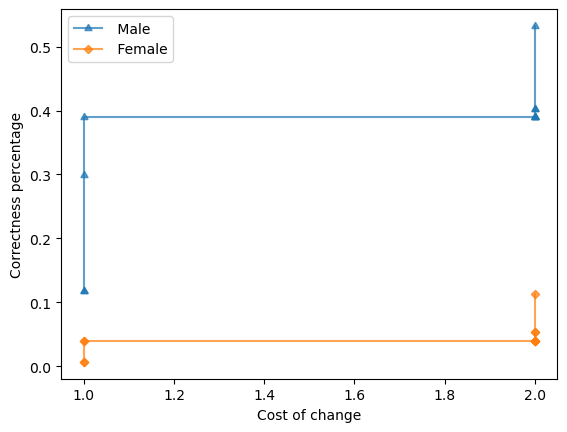

If age = (26.0, 34.0], native-country =  United-States, occupation =  Machine-op-inspct:
	Protected Subgroup ' Male', 2.03% covered out of 6761
		Make occupation =  Sales with correctness 4.23% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 6.34% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 7.04% and counterfactual cost = 1.0.
		Make age = (34.0, 41.0], occupation =  Craft-repair with correctness 7.04% and counterfactual cost = 2.0.
		Make age = (34.0, 41.0], occupation =  Sales with correctness 8.45% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Craft-repair with correctness 8.45% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Adm-clerical with correctness 9.15% and counterfactual cost = 2.0.
		Make age = (34.0, 41.0], occupation =  Prof-specialty with correctness 21.83% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Sales with correc

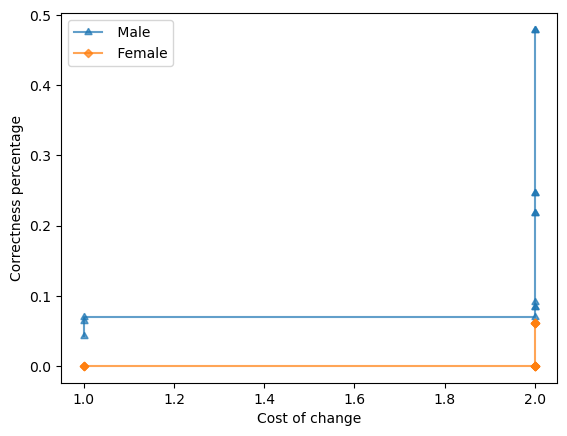

If Workclass =  Private, capital-loss = 0, education-num = 9, occupation =  Craft-repair:
	Protected Subgroup ' Male', 8.42% covered out of 6761
		Make occupation =  Exec-managerial with correctness 20.03% and counterfactual cost = 1.0.
		Make education-num = 10, occupation =  Sales with correctness 20.03% and counterfactual cost = 2.33.
		Make education-num = 10, occupation =  Prof-specialty with correctness 28.05% and counterfactual cost = 2.33.
		Make education-num = 10, occupation =  Exec-managerial with correctness 37.46% and counterfactual cost = 2.33.
		Make Workclass =  Self-emp-inc, education-num = 10, occupation =  Exec-managerial with correctness 44.43% and counterfactual cost = 3.33.
		Make education-num = 11, occupation =  Exec-managerial with correctness 45.30% and counterfactual cost = 3.67.
		Aggregate cost of the above recourses = 0.45
	Protected Subgroup ' Female', 1.08% covered out of 4067
		Make occupation =  Exec-managerial with correctness 0.00% and counterfactual

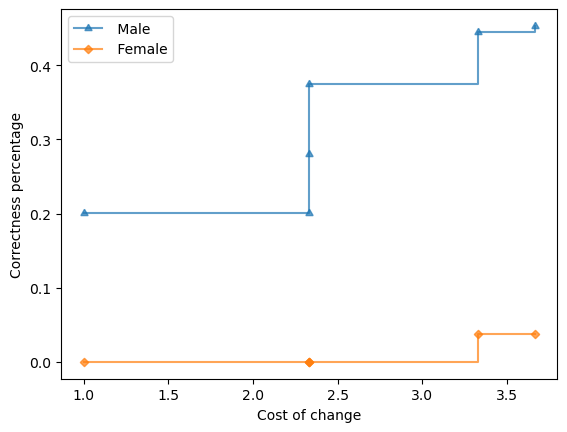

If Workclass =  Private, age = (41.0, 50.0], capital-gain = 0, occupation =  Machine-op-inspct:
	Protected Subgroup ' Male', 1.61% covered out of 6761
		Make occupation =  Craft-repair with correctness 6.19% and counterfactual cost = 1.0.
		Make occupation =  Sales with correctness 20.35% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 29.20% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 43.36% and counterfactual cost = 1.0.
		Make age = (50.0, 90.0], occupation =  Sales with correctness 43.36% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Exec-managerial with correctness 43.36% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Prof-specialty with correctness 43.36% and counterfactual cost = 2.0.
		Make Workclass =  Local-gov, occupation =  Prof-specialty with correctness 43.36% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc, age = (50.0, 90.0], oc

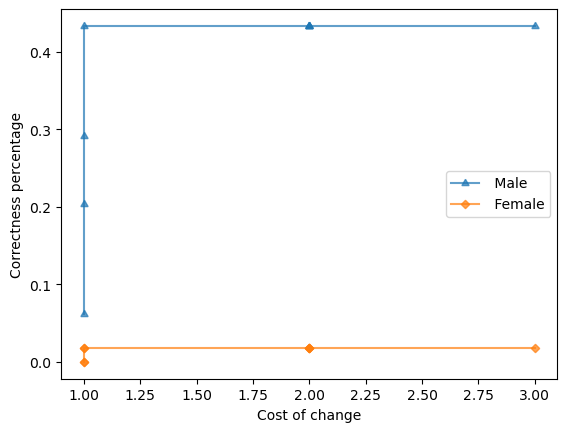

If Workclass =  Private, education-num = 9, native-country =  United-States, occupation =  Craft-repair:
	Protected Subgroup ' Male', 8.11% covered out of 6761
		Make occupation =  Sales with correctness 3.44% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 20.29% and counterfactual cost = 1.0.
		Make education-num = 10, occupation =  Sales with correctness 20.29% and counterfactual cost = 2.33.
		Make education-num = 10, occupation =  Prof-specialty with correctness 28.62% and counterfactual cost = 2.33.
		Make education-num = 10, occupation =  Exec-managerial with correctness 38.22% and counterfactual cost = 2.33.
		Make Workclass =  Self-emp-inc, education-num = 10, occupation =  Exec-managerial with correctness 44.57% and counterfactual cost = 3.33.
		Make education-num = 11, occupation =  Exec-managerial with correctness 45.29% and counterfactual cost = 3.67.
		Aggregate cost of the above recourses = 0.45
	Protected Subgroup ' Female', 1.03% co

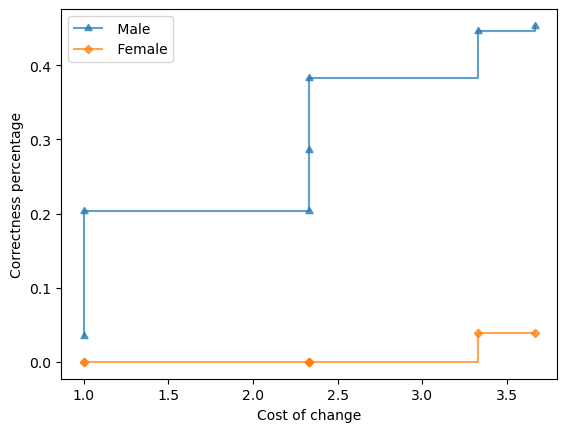

If capital-loss = 0, native-country =  United-States, occupation =  Machine-op-inspct:
	Protected Subgroup ' Male', 8.08% covered out of 6761
		Make occupation =  Craft-repair with correctness 2.96% and counterfactual cost = 1.0.
		Make occupation =  Transport-moving with correctness 2.96% and counterfactual cost = 1.0.
		Make occupation =  Adm-clerical with correctness 4.07% and counterfactual cost = 1.0.
		Make occupation =  Protective-serv with correctness 11.30% and counterfactual cost = 1.0.
		Make occupation =  Sales with correctness 11.30% and counterfactual cost = 1.0.
		Make occupation =  Tech-support with correctness 11.48% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 14.26% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 18.52% and counterfactual cost = 1.0.
		Make capital-loss = 1902, occupation =  Prof-specialty with correctness 47.04% and counterfactual cost = 1.5.
		Aggregate cost of the above re

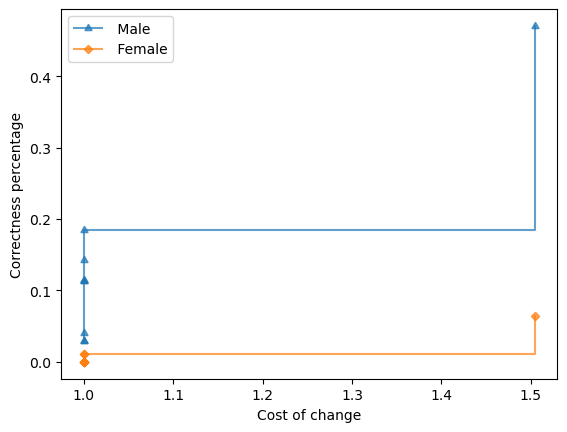

If capital-loss = 0, education-num = 11, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 3.58% covered out of 6761
		Make education-num = 12 with correctness 13.21% and counterfactual cost = 1.33.
		Make education-num = 13 with correctness 24.53% and counterfactual cost = 2.67.
		Make capital-loss = 1902, education-num = 13 with correctness 57.08% and counterfactual cost = 3.17.
		Aggregate cost of the above recourses = 0.57
	Protected Subgroup ' Female', 3.39% covered out of 4067
		Make education-num = 12 with correctness 1.67% and counterfactual cost = 1.33.
		Make education-num = 13 with correctness 5.83% and counterfactual cost = 2.67.
		Make capital-loss = 1902, education-num = 13 with correctness 16.67% and counterfactual cost = 3.17.
		Aggregate cost of the above recourses = 0.17
	Bias against  Female. Unfairness measure = 0.404.
	Cumulative correctness plot for the above recourses:


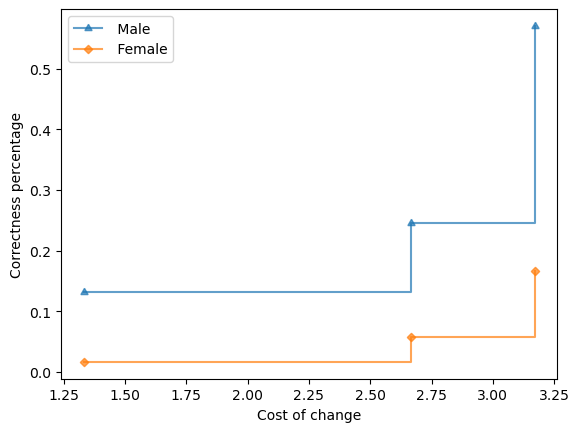

If Workclass =  Private, age = (26.0, 34.0], capital-loss = 0, occupation =  Machine-op-inspct:
	Protected Subgroup ' Male', 2.10% covered out of 6761
		Make occupation =  Sales with correctness 2.63% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 3.29% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 3.95% and counterfactual cost = 1.0.
		Make age = (34.0, 41.0], occupation =  Sales with correctness 5.26% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Craft-repair with correctness 5.26% and counterfactual cost = 2.0.
		Make age = (34.0, 41.0], occupation =  Craft-repair with correctness 5.26% and counterfactual cost = 2.0.
		Make age = (34.0, 41.0], occupation =  Prof-specialty with correctness 17.76% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Sales with correctness 17.76% and counterfactual cost = 2.0.
		Make age = (34.0, 41.0], occupation =  Exec-managerial 

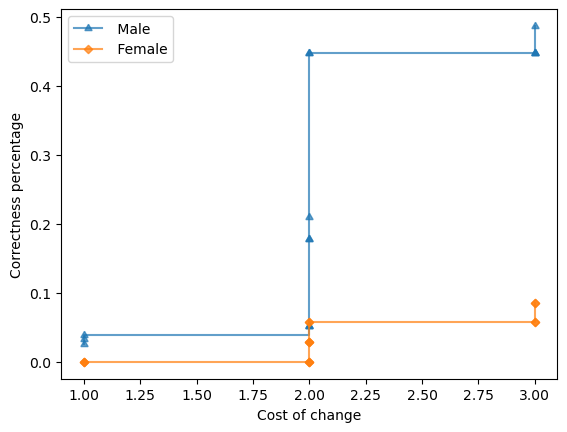

If age = (41.0, 50.0], occupation =  Machine-op-inspct:
	Protected Subgroup ' Male', 1.70% covered out of 6761
		Make occupation =  Craft-repair with correctness 7.20% and counterfactual cost = 1.0.
		Make occupation =  Adm-clerical with correctness 9.60% and counterfactual cost = 1.0.
		Make occupation =  Sales with correctness 21.60% and counterfactual cost = 1.0.
		Make occupation =  Tech-support with correctness 29.60% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 30.40% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 43.20% and counterfactual cost = 1.0.
		Make age = (50.0, 90.0], occupation =  Craft-repair with correctness 43.20% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Adm-clerical with correctness 43.20% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Sales with correctness 43.20% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =

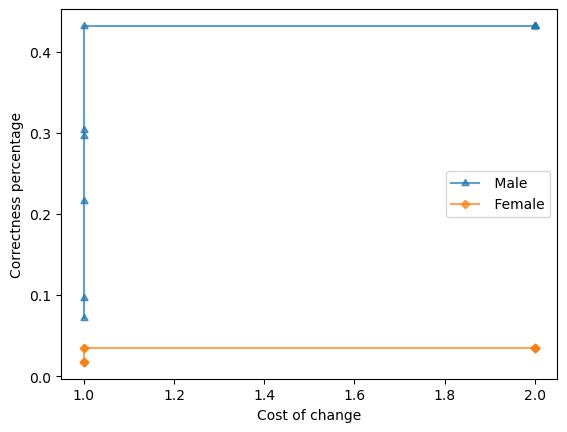

If capital-loss = 0, native-country =  United-States, occupation =  Craft-repair, race =  White:
	Protected Subgroup ' Male', 18.51% covered out of 6761
		Make occupation =  Transport-moving with correctness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Adm-clerical with correctness 1.27% and counterfactual cost = 1.0.
		Make occupation =  Protective-serv with correctness 10.43% and counterfactual cost = 1.0.
		Make occupation =  Sales with correctness 10.43% and counterfactual cost = 1.0.
		Make occupation =  Tech-support with correctness 10.99% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 14.01% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 20.54% and counterfactual cost = 1.0.
		Make capital-loss = 1902, occupation =  Prof-specialty with correctness 52.07% and counterfactual cost = 1.5.
		Aggregate cost of the above recourses = 0.52
	Protected Subgroup ' Female', 1.59% covered out of 4067
		Mak

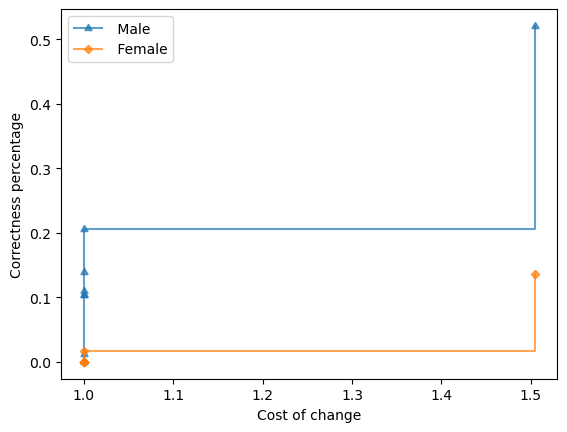

If Workclass =  Private, capital-gain = 0, capital-loss = 0, education-num = 11, hours-per-week = FullTime, race =  White:
	Protected Subgroup ' Male', 1.76% covered out of 6761
		Make education-num = 13 with correctness 26.85% and counterfactual cost = 2.67.
		Make education-num = 13, hours-per-week = OverTime with correctness 44.44% and counterfactual cost = 3.67.
		Make education-num = 13, hours-per-week = BrainDrain with correctness 44.44% and counterfactual cost = 3.67.
		Aggregate cost of the above recourses = 0.44
	Protected Subgroup ' Female', 1.52% covered out of 4067
		Make education-num = 13 with correctness 6.12% and counterfactual cost = 2.67.
		Make education-num = 13, hours-per-week = OverTime with correctness 6.12% and counterfactual cost = 3.67.
		Make education-num = 13, hours-per-week = BrainDrain with correctness 6.12% and counterfactual cost = 3.67.
		Aggregate cost of the above recourses = 0.06
	Bias against  Female. Unfairness measure = 0.383.
	Cumulative correct

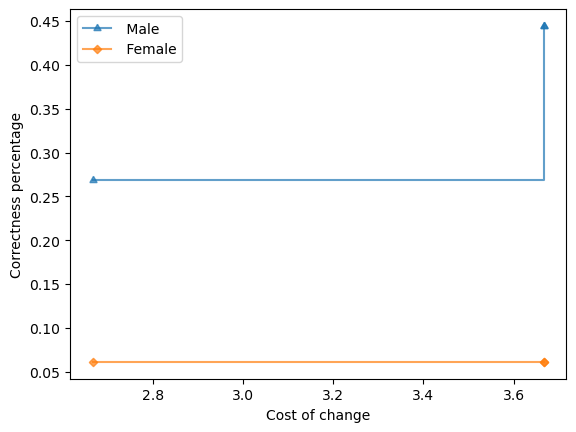

If capital-gain = 0, capital-loss = 0, education-num = 11, hours-per-week = FullTime, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 2.02% covered out of 6761
		Make education-num = 12 with correctness 12.70% and counterfactual cost = 1.33.
		Make education-num = 12, hours-per-week = OverTime with correctness 30.95% and counterfactual cost = 2.33.
		Make education-num = 13 with correctness 30.95% and counterfactual cost = 2.67.
		Make education-num = 13, hours-per-week = OverTime with correctness 43.65% and counterfactual cost = 3.67.
		Make education-num = 13, hours-per-week = BrainDrain with correctness 43.65% and counterfactual cost = 3.67.
		Aggregate cost of the above recourses = 0.44
	Protected Subgroup ' Female', 1.61% covered out of 4067
		Make education-num = 12 with correctness 0.00% and counterfactual cost = 1.33.
		Make education-num = 12, hours-per-week = OverTime with correctness 5.36% and counterfactual cost = 2.33.
		Make education-num = 13

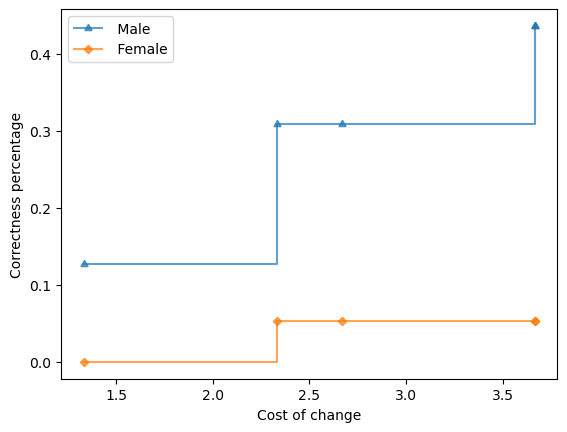

If capital-gain = 0, education-num = 9, native-country =  United-States, occupation =  Sales, race =  White:
	Protected Subgroup ' Male', 3.08% covered out of 6761
		Make occupation =  Exec-managerial with correctness 21.76% and counterfactual cost = 1.0.
		Make education-num = 10 with correctness 21.76% and counterfactual cost = 1.33.
		Make education-num = 10, occupation =  Prof-specialty with correctness 25.93% and counterfactual cost = 2.33.
		Make education-num = 10, occupation =  Exec-managerial with correctness 32.41% and counterfactual cost = 2.33.
		Make education-num = 11, occupation =  Exec-managerial with correctness 43.52% and counterfactual cost = 3.67.
		Aggregate cost of the above recourses = 0.44
	Protected Subgroup ' Female', 3.61% covered out of 4067
		Make occupation =  Exec-managerial with correctness 1.33% and counterfactual cost = 1.0.
		Make education-num = 10 with correctness 1.33% and counterfactual cost = 1.33.
		Make education-num = 10, occupation =  Exec-ma

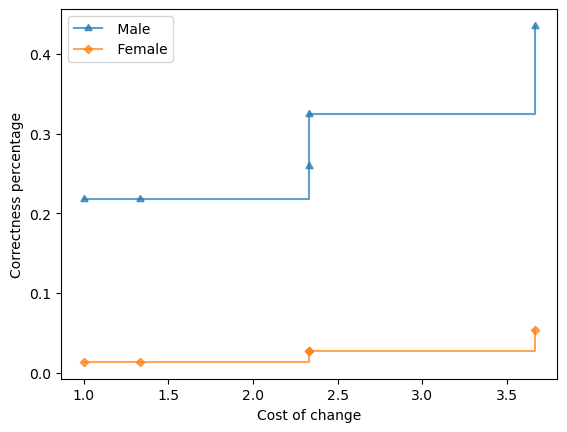

If Workclass =  Private, age = (34.0, 41.0], native-country =  United-States, occupation =  Machine-op-inspct:
	Protected Subgroup ' Male', 1.76% covered out of 6761
		Make occupation =  Craft-repair with correctness 5.05% and counterfactual cost = 1.0.
		Make occupation =  Sales with correctness 9.09% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 23.23% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 28.28% and counterfactual cost = 1.0.
		Make age = (41.0, 50.0], occupation =  Craft-repair with correctness 28.28% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Sales with correctness 28.28% and counterfactual cost = 2.0.
		Make Workclass =  Local-gov, occupation =  Prof-specialty with correctness 28.28% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Sales with correctness 28.28% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Exec-manageri

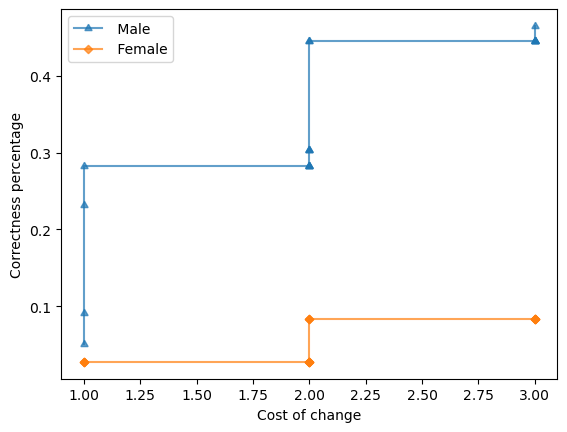

In [18]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="min-above-cost",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "remove-above-thr-cost"
        #"remove-below-thr",
        #"keep-only-min-change",
        
    ],
    cost_threshold = 10,
    params=params
)

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric = True
)

## Fairness of Recourse

If Workclass =  Private, age = (26.0, 34.0], native-country =  United-States, occupation =  Machine-op-inspct:
	Protected Subgroup ' Male', 1.91% covered out of 6761
		Make occupation =  Sales with correctness 4.48% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 6.72% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 6.72% and counterfactual cost = 1.0.
		Make age = (34.0, 41.0], occupation =  Sales with correctness 8.21% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Craft-repair with correctness 8.21% and counterfactual cost = 2.0.
		Make age = (34.0, 41.0], occupation =  Craft-repair with correctness 8.21% and counterfactual cost = 2.0.
		Make age = (34.0, 41.0], occupation =  Prof-specialty with correctness 22.39% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Sales with correctness 22.39% and counterfactual cost = 2.0.
		Make age = (34.0, 41.0], occupation =  E

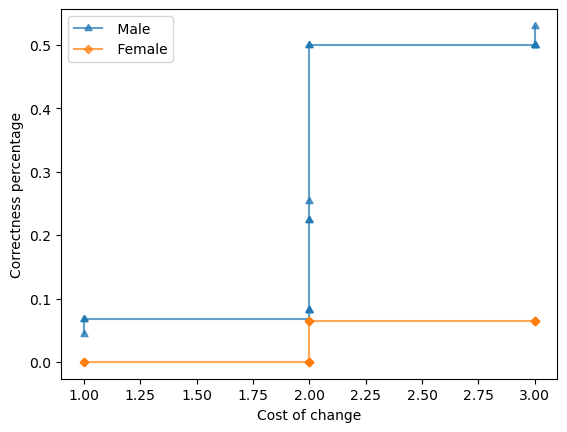

If capital-loss = 0, native-country =  United-States, occupation =  Machine-op-inspct:
	Protected Subgroup ' Male', 8.08% covered out of 6761
		Make occupation =  Craft-repair with correctness 2.96% and counterfactual cost = 1.0.
		Make occupation =  Transport-moving with correctness 2.96% and counterfactual cost = 1.0.
		Make occupation =  Adm-clerical with correctness 4.07% and counterfactual cost = 1.0.
		Make occupation =  Protective-serv with correctness 11.30% and counterfactual cost = 1.0.
		Make occupation =  Sales with correctness 11.30% and counterfactual cost = 1.0.
		Make occupation =  Tech-support with correctness 11.48% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 14.26% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 18.52% and counterfactual cost = 1.0.
		Make capital-loss = 1902, occupation =  Prof-specialty with correctness 47.04% and counterfactual cost = 1.5.
	Protected Subgroup ' Female', 4

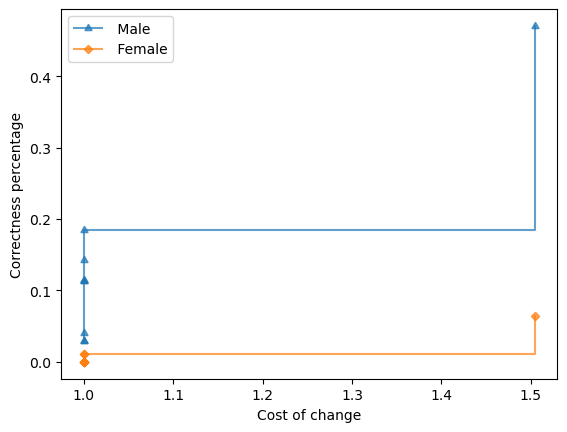

If age = (50.0, 90.0], capital-gain = 0, capital-loss = 0:
	Protected Subgroup ' Male', 17.54% covered out of 6761
		Make capital-gain = 7298 with correctness 69.44% and counterfactual cost = 0.07.
		Make capital-gain = 15024 with correctness 97.07% and counterfactual cost = 0.15.
	Protected Subgroup ' Female', 15.83% covered out of 4067
		Make capital-gain = 7298 with correctness 32.08% and counterfactual cost = 0.07.
		Make capital-gain = 15024 with correctness 88.70% and counterfactual cost = 0.15.
	 Unfairness based on the Kolmogorov-Smirnov test = 0.34.
	Cumulative correctness plot for the above recourses:


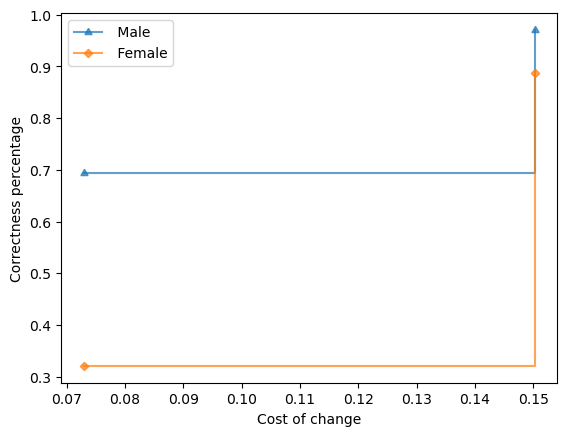

If capital-loss = 0, native-country =  United-States, occupation =  Machine-op-inspct, race =  White:
	Protected Subgroup ' Male', 7.05% covered out of 6761
		Make occupation =  Craft-repair with correctness 3.23% and counterfactual cost = 1.0.
		Make occupation =  Transport-moving with correctness 3.23% and counterfactual cost = 1.0.
		Make occupation =  Adm-clerical with correctness 4.53% and counterfactual cost = 1.0.
		Make occupation =  Protective-serv with correctness 12.07% and counterfactual cost = 1.0.
		Make occupation =  Sales with correctness 12.07% and counterfactual cost = 1.0.
		Make occupation =  Tech-support with correctness 12.07% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 15.30% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 19.61% and counterfactual cost = 1.0.
		Make capital-loss = 1902, occupation =  Prof-specialty with correctness 49.35% and counterfactual cost = 1.5.
	Protected Subgro

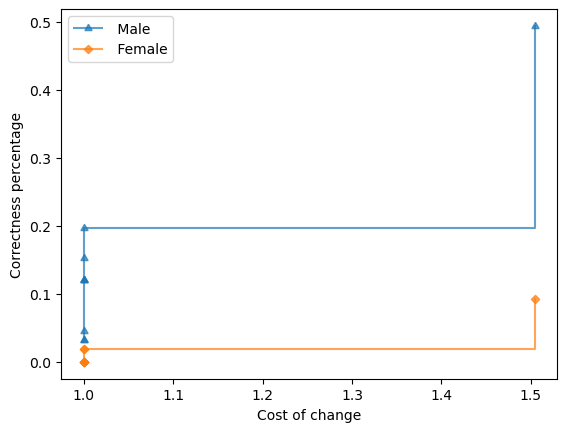

If capital-gain = 0, capital-loss = 0, native-country =  United-States, occupation =  Craft-repair, race =  White:
	Protected Subgroup ' Male', 17.85% covered out of 6761
		Make occupation =  Adm-clerical with correctness 1.32% and counterfactual cost = 1.0.
		Make occupation =  Sales with correctness 5.78% and counterfactual cost = 1.0.
		Make occupation =  Tech-support with correctness 10.73% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 13.87% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 20.48% and counterfactual cost = 1.0.
		Make capital-gain = 7688, occupation =  Prof-specialty with correctness 71.84% and counterfactual cost = 1.08.
		Make capital-gain = 7688, occupation =  Exec-managerial with correctness 74.32% and counterfactual cost = 1.08.
		Make capital-gain = 15024, occupation =  Prof-specialty with correctness 95.13% and counterfactual cost = 1.15.
		Make capital-gain = 15024, occupation =  Exec

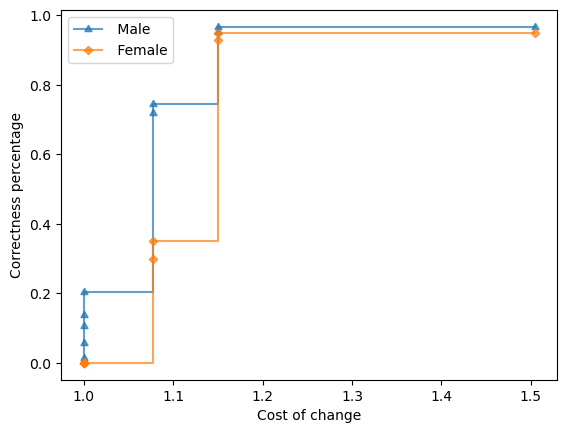

If capital-loss = 0, education-num = 11, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 3.58% covered out of 6761
		Make education-num = 12 with correctness 13.21% and counterfactual cost = 1.33.
		Make education-num = 13 with correctness 24.53% and counterfactual cost = 2.67.
		Make capital-loss = 1902, education-num = 13 with correctness 57.08% and counterfactual cost = 3.17.
	Protected Subgroup ' Female', 3.39% covered out of 4067
		Make education-num = 12 with correctness 1.67% and counterfactual cost = 1.33.
		Make education-num = 13 with correctness 5.83% and counterfactual cost = 2.67.
		Make capital-loss = 1902, education-num = 13 with correctness 16.67% and counterfactual cost = 3.17.
	 Unfairness based on the Kolmogorov-Smirnov test = 0.34.
	Cumulative correctness plot for the above recourses:


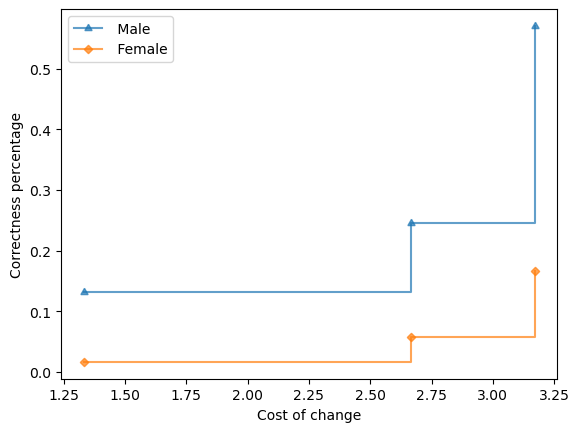

If capital-loss = 0, education-num = 11, race =  White:
	Protected Subgroup ' Male', 3.75% covered out of 6761
		Make education-num = 12 with correctness 12.95% and counterfactual cost = 1.33.
		Make education-num = 13 with correctness 24.11% and counterfactual cost = 2.67.
		Make capital-loss = 1902, education-num = 13 with correctness 56.70% and counterfactual cost = 3.17.
		Make education-num = 13, race =  Asian-Pac-Islander with correctness 56.70% and counterfactual cost = 3.67.
	Protected Subgroup ' Female', 3.73% covered out of 4067
		Make education-num = 12 with correctness 1.59% and counterfactual cost = 1.33.
		Make education-num = 13 with correctness 5.56% and counterfactual cost = 2.67.
		Make capital-loss = 1902, education-num = 13 with correctness 16.67% and counterfactual cost = 3.17.
		Make education-num = 13, race =  Asian-Pac-Islander with correctness 16.67% and counterfactual cost = 3.67.
	 Unfairness based on the Kolmogorov-Smirnov test = 0.34.
	Cumulative correctnes

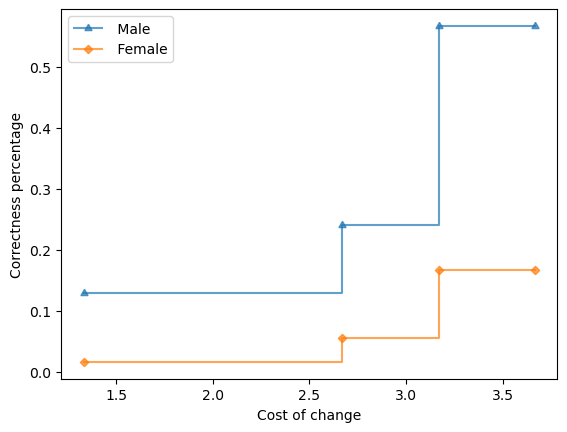

If age = (50.0, 90.0], capital-gain = 0:
	Protected Subgroup ' Male', 18.00% covered out of 6761
		Make capital-gain = 7298 with correctness 69.88% and counterfactual cost = 0.07.
		Make capital-gain = 15024 with correctness 97.15% and counterfactual cost = 0.15.
	Protected Subgroup ' Female', 16.21% covered out of 4067
		Make capital-gain = 7298 with correctness 33.19% and counterfactual cost = 0.07.
		Make capital-gain = 15024 with correctness 88.99% and counterfactual cost = 0.15.
	 Unfairness based on the Kolmogorov-Smirnov test = 0.34.
	Cumulative correctness plot for the above recourses:


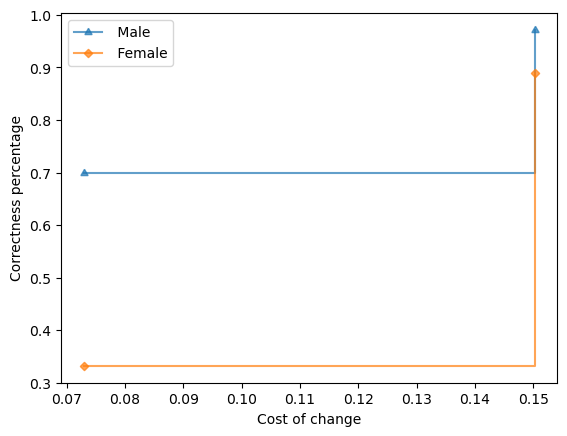

If age = (34.0, 41.0], capital-gain = 0, capital-loss = 0, occupation =  Adm-clerical:
	Protected Subgroup ' Male', 1.07% covered out of 6761
		Make age = (41.0, 50.0] with correctness 11.69% and counterfactual cost = 1.0.
		Make occupation =  Sales with correctness 11.69% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 29.87% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 38.96% and counterfactual cost = 1.0.
		Make age = (41.0, 50.0], occupation =  Craft-repair with correctness 38.96% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Sales with correctness 38.96% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Sales with correctness 38.96% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Prof-specialty with correctness 38.96% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Exec-managerial with correctness 40.26% and cou

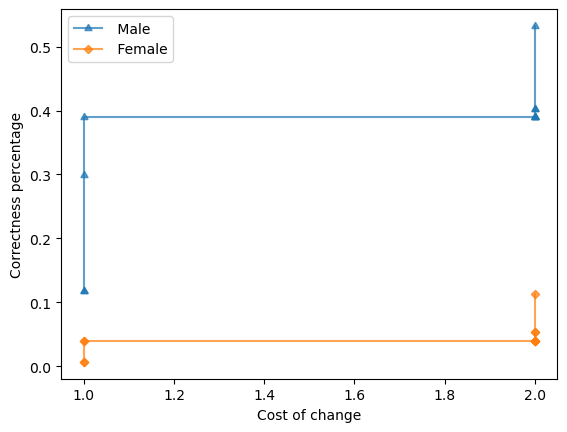

If capital-gain = 0, native-country =  United-States, occupation =  Craft-repair, race =  White:
	Protected Subgroup ' Male', 18.35% covered out of 6761
		Make occupation =  Transport-moving with correctness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Adm-clerical with correctness 1.29% and counterfactual cost = 1.0.
		Make occupation =  Sales with correctness 5.89% and counterfactual cost = 1.0.
		Make occupation =  Tech-support with correctness 11.05% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 14.11% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 20.65% and counterfactual cost = 1.0.
		Make capital-gain = 7688, occupation =  Prof-specialty with correctness 72.18% and counterfactual cost = 1.08.
		Make capital-gain = 7688, occupation =  Exec-managerial with correctness 74.68% and counterfactual cost = 1.08.
		Make capital-gain = 15024, occupation =  Prof-specialty with correctness 95.24% and c

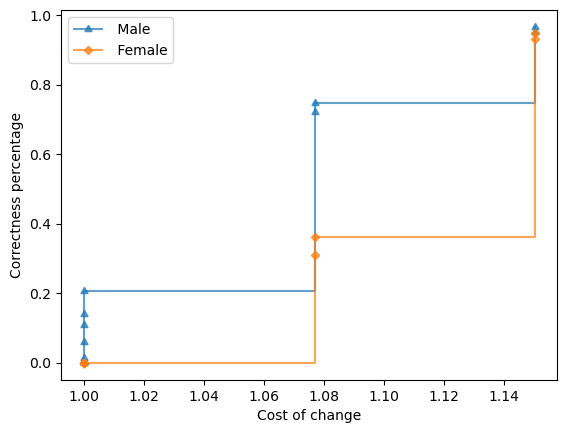

If Workclass =  Private, age = (16.999, 26.0], capital-gain = 0, hours-per-week = PartTime, marital-status =  Never-married, occupation =  Other-service, relationship =  Own-child:
	Protected Subgroup ' Male', 1.06% covered out of 6761
		Make age = (26.0, 34.0], hours-per-week = FullTime, marital-status =  Married-civ-spouse, occupation =  Prof-specialty, relationship =  Married with correctness 2.74% and counterfactual cost = 14.0.
		Make age = (26.0, 34.0], hours-per-week = FullTime, marital-status =  Married-civ-spouse, occupation =  Exec-managerial, relationship =  Married with correctness 2.74% and counterfactual cost = 14.0.
		Make age = (26.0, 34.0], hours-per-week = OverTime, marital-status =  Married-civ-spouse, occupation =  Prof-specialty, relationship =  Married with correctness 4.11% and counterfactual cost = 14.0.
		Make age = (26.0, 34.0], hours-per-week = OverTime, marital-status =  Married-civ-spouse, occupation =  Exec-managerial, relationship =  Married with correctn

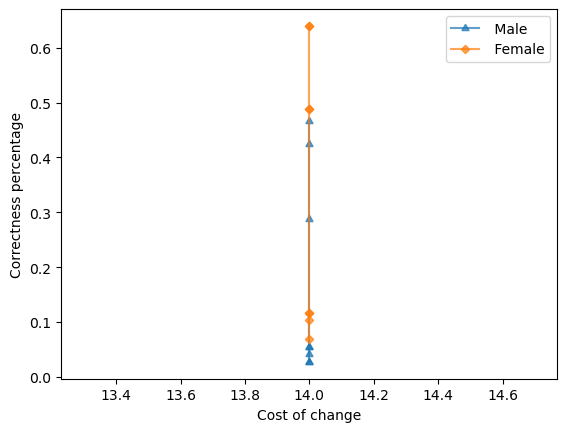

If capital-loss = 0, education-num = 11, native-country =  United-States:
	Protected Subgroup ' Male', 3.90% covered out of 6761
		Make education-num = 12 with correctness 11.81% and counterfactual cost = 1.33.
		Make education-num = 13 with correctness 23.63% and counterfactual cost = 2.67.
		Make capital-loss = 1902, education-num = 13 with correctness 54.43% and counterfactual cost = 3.17.
	Protected Subgroup ' Female', 4.19% covered out of 4067
		Make education-num = 12 with correctness 1.34% and counterfactual cost = 1.33.
		Make education-num = 13 with correctness 5.37% and counterfactual cost = 2.67.
		Make capital-loss = 1902, education-num = 13 with correctness 15.44% and counterfactual cost = 3.17.
	 Unfairness based on the Kolmogorov-Smirnov test = 0.33.
	Cumulative correctness plot for the above recourses:


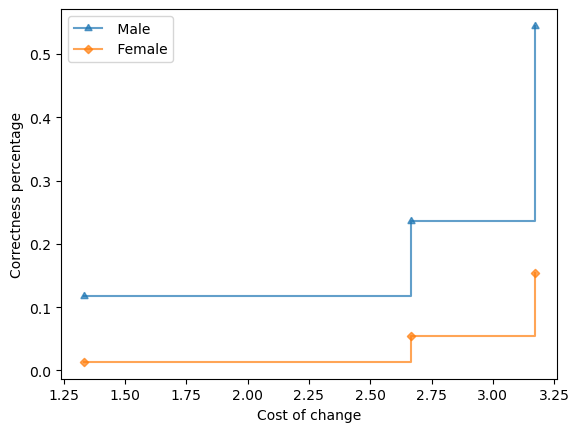

If age = (34.0, 41.0], capital-loss = 0, occupation =  Adm-clerical:
	Protected Subgroup ' Male', 1.09% covered out of 6761
		Make occupation =  Craft-repair with correctness 0.00% and counterfactual cost = 1.0.
		Make age = (50.0, 90.0] with correctness 5.19% and counterfactual cost = 1.0.
		Make age = (41.0, 50.0] with correctness 11.69% and counterfactual cost = 1.0.
		Make occupation =  Sales with correctness 11.69% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 29.87% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 38.96% and counterfactual cost = 1.0.
		Make age = (50.0, 90.0], occupation =  Craft-repair with correctness 38.96% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Craft-repair with correctness 38.96% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Sales with correctness 38.96% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  S

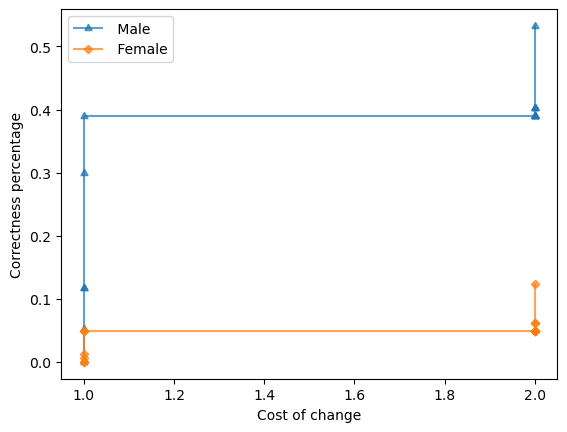

If capital-loss = 0, education-num = 11:
	Protected Subgroup ' Male', 4.13% covered out of 6761
		Make education-num = 12 with correctness 11.76% and counterfactual cost = 1.33.
		Make education-num = 13 with correctness 23.14% and counterfactual cost = 2.67.
		Make capital-loss = 1902, education-num = 13 with correctness 54.51% and counterfactual cost = 3.17.
	Protected Subgroup ' Female', 4.57% covered out of 4067
		Make education-num = 12 with correctness 1.25% and counterfactual cost = 1.33.
		Make education-num = 13 with correctness 5.00% and counterfactual cost = 2.67.
		Make capital-loss = 1902, education-num = 13 with correctness 16.25% and counterfactual cost = 3.17.
	 Unfairness based on the Kolmogorov-Smirnov test = 0.32.
	Cumulative correctness plot for the above recourses:


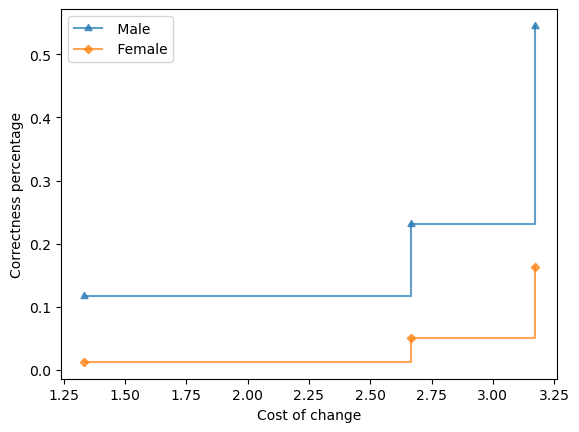

If capital-gain = 0, capital-loss = 0, occupation =  Craft-repair, race =  White:
	Protected Subgroup ' Male', 19.14% covered out of 6761
		Make occupation =  Adm-clerical with correctness 1.22% and counterfactual cost = 1.0.
		Make occupation =  Sales with correctness 5.50% and counterfactual cost = 1.0.
		Make occupation =  Tech-support with correctness 10.24% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 13.22% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 19.71% and counterfactual cost = 1.0.
		Make capital-gain = 7688, occupation =  Prof-specialty with correctness 70.13% and counterfactual cost = 1.08.
		Make capital-gain = 7688, occupation =  Exec-managerial with correctness 72.50% and counterfactual cost = 1.08.
		Make capital-gain = 15024, occupation =  Prof-specialty with correctness 94.27% and counterfactual cost = 1.15.
		Make capital-gain = 15024, occupation =  Exec-managerial with correctness 95.8

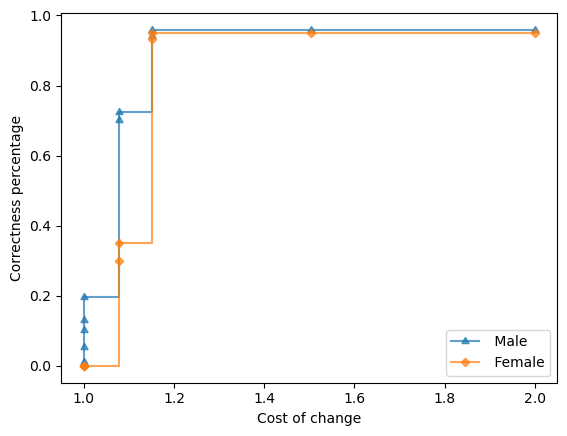

If capital-gain = 0, occupation =  Craft-repair, race =  White:
	Protected Subgroup ' Male', 19.66% covered out of 6761
		Make occupation =  Transport-moving with correctness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Adm-clerical with correctness 1.19% and counterfactual cost = 1.0.
		Make occupation =  Sales with correctness 5.60% and counterfactual cost = 1.0.
		Make occupation =  Tech-support with correctness 10.52% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 13.43% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 19.85% and counterfactual cost = 1.0.
		Make capital-gain = 7688, occupation =  Prof-specialty with correctness 70.37% and counterfactual cost = 1.08.
		Make capital-gain = 7688, occupation =  Exec-managerial with correctness 72.76% and counterfactual cost = 1.08.
		Make capital-gain = 15024, occupation =  Prof-specialty with correctness 94.40% and counterfactual cost = 1.15.
		Make

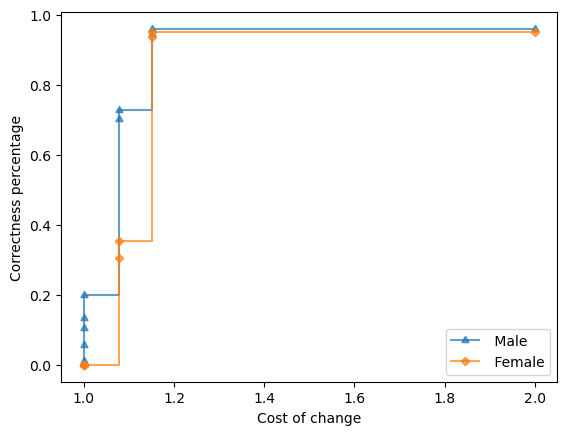

If Workclass =  Private, capital-loss = 0, education-num = 9, occupation =  Craft-repair:
	Protected Subgroup ' Male', 8.42% covered out of 6761
		Make occupation =  Exec-managerial with correctness 20.03% and counterfactual cost = 1.0.
		Make education-num = 10, occupation =  Sales with correctness 20.03% and counterfactual cost = 2.33.
		Make education-num = 10, occupation =  Prof-specialty with correctness 28.05% and counterfactual cost = 2.33.
		Make education-num = 10, occupation =  Exec-managerial with correctness 37.46% and counterfactual cost = 2.33.
		Make Workclass =  Self-emp-inc, education-num = 10, occupation =  Exec-managerial with correctness 44.43% and counterfactual cost = 3.33.
		Make education-num = 11, occupation =  Exec-managerial with correctness 45.30% and counterfactual cost = 3.67.
	Protected Subgroup ' Female', 1.08% covered out of 4067
		Make occupation =  Exec-managerial with correctness 0.00% and counterfactual cost = 1.0.
		Make education-num = 10, occupat

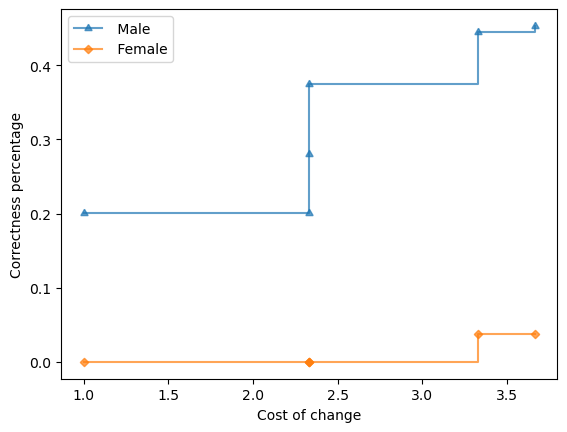

If Workclass =  Private, education-num = 9, occupation =  Craft-repair:
	Protected Subgroup ' Male', 8.60% covered out of 6761
		Make occupation =  Sales with correctness 3.23% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 19.90% and counterfactual cost = 1.0.
		Make education-num = 10, occupation =  Sales with correctness 19.90% and counterfactual cost = 2.33.
		Make education-num = 10, occupation =  Prof-specialty with correctness 27.72% and counterfactual cost = 2.33.
		Make education-num = 10, occupation =  Exec-managerial with correctness 37.07% and counterfactual cost = 2.33.
		Make Workclass =  Self-emp-inc, education-num = 10, occupation =  Exec-managerial with correctness 44.05% and counterfactual cost = 3.33.
		Make education-num = 11, occupation =  Exec-managerial with correctness 44.90% and counterfactual cost = 3.67.
	Protected Subgroup ' Female', 1.13% covered out of 4067
		Make occupation =  Sales with correctness 0.00% and counterf

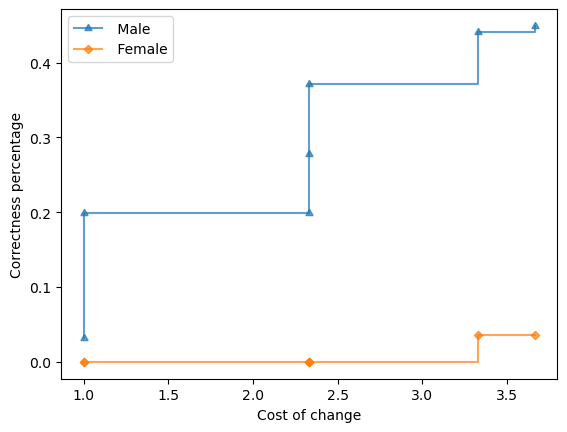

If age = (34.0, 41.0], capital-gain = 0, occupation =  Adm-clerical:
	Protected Subgroup ' Male', 1.09% covered out of 6761
		Make occupation =  Craft-repair with correctness 0.00% and counterfactual cost = 1.0.
		Make age = (41.0, 50.0] with correctness 11.25% and counterfactual cost = 1.0.
		Make occupation =  Sales with correctness 11.25% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 28.75% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 37.50% and counterfactual cost = 1.0.
		Make age = (41.0, 50.0], occupation =  Craft-repair with correctness 37.50% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Sales with correctness 37.50% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Sales with correctness 37.50% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Prof-specialty with correctness 37.50% and counterfactual cost = 2.0.
		Make age = (50.0

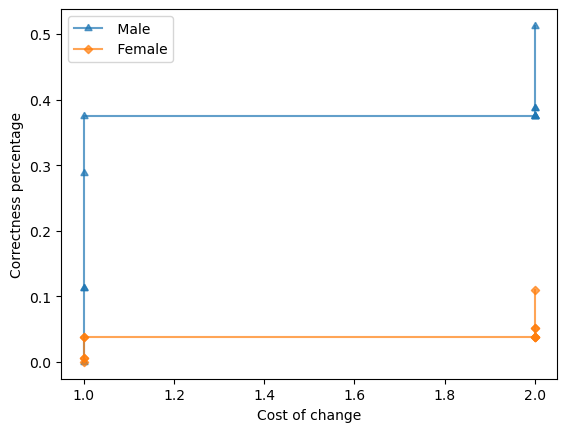

If Workclass =  Private, age = (50.0, 90.0], capital-loss = 0, occupation =  Sales:
	Protected Subgroup ' Male', 1.09% covered out of 6761
		Make occupation =  Prof-specialty with correctness 35.94% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 37.50% and counterfactual cost = 1.0.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with correctness 48.44% and counterfactual cost = 2.0.
	Protected Subgroup ' Female', 1.61% covered out of 4067
		Make occupation =  Exec-managerial with correctness 4.76% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 4.76% and counterfactual cost = 1.0.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with correctness 6.35% and counterfactual cost = 2.0.
	 Unfairness based on the Kolmogorov-Smirnov test = 0.32.
	Cumulative correctness plot for the above recourses:


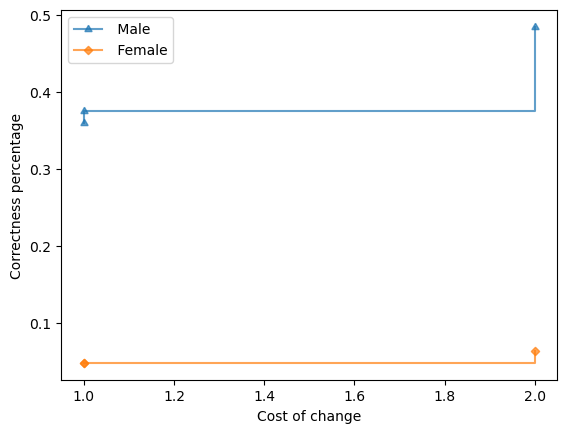

If age = (41.0, 50.0], capital-loss = 0, native-country =  United-States:
	Protected Subgroup ' Male', 13.32% covered out of 6761
		Make capital-loss = 1902 with correctness 51.70% and counterfactual cost = 0.5.
		Make age = (50.0, 90.0] with correctness 51.70% and counterfactual cost = 1.0.
	Protected Subgroup ' Female', 13.83% covered out of 4067
		Make capital-loss = 1902 with correctness 16.70% and counterfactual cost = 0.5.
		Make age = (50.0, 90.0] with correctness 16.70% and counterfactual cost = 1.0.
	 Unfairness based on the Kolmogorov-Smirnov test = 0.32.
	Cumulative correctness plot for the above recourses:


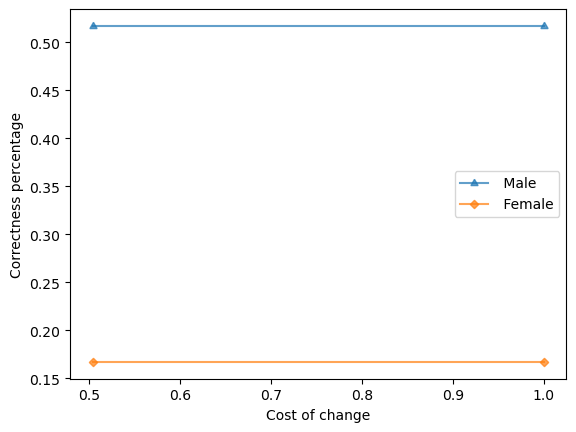

If Workclass =  Private, education-num = 9, native-country =  United-States, occupation =  Craft-repair:
	Protected Subgroup ' Male', 8.11% covered out of 6761
		Make occupation =  Sales with correctness 3.44% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 20.29% and counterfactual cost = 1.0.
		Make education-num = 10, occupation =  Sales with correctness 20.29% and counterfactual cost = 2.33.
		Make education-num = 10, occupation =  Prof-specialty with correctness 28.62% and counterfactual cost = 2.33.
		Make education-num = 10, occupation =  Exec-managerial with correctness 38.22% and counterfactual cost = 2.33.
		Make Workclass =  Self-emp-inc, education-num = 10, occupation =  Exec-managerial with correctness 44.57% and counterfactual cost = 3.33.
		Make education-num = 11, occupation =  Exec-managerial with correctness 45.29% and counterfactual cost = 3.67.
	Protected Subgroup ' Female', 1.03% covered out of 4067
		Make occupation =  Sales wi

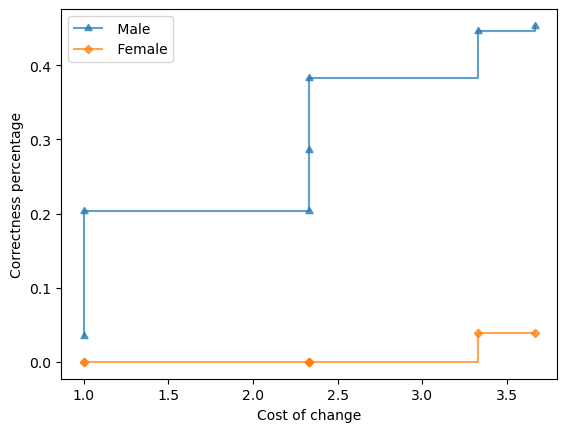

If education-num = 9, native-country =  United-States, occupation =  Sales, race =  White:
	Protected Subgroup ' Male', 3.18% covered out of 6761
		Make occupation =  Craft-repair with correctness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 21.92% and counterfactual cost = 1.0.
		Make education-num = 10 with correctness 21.92% and counterfactual cost = 1.33.
		Make education-num = 10, occupation =  Prof-specialty with correctness 26.03% and counterfactual cost = 2.33.
		Make education-num = 10, occupation =  Exec-managerial with correctness 32.42% and counterfactual cost = 2.33.
		Make education-num = 11, occupation =  Prof-specialty with correctness 41.10% and counterfactual cost = 3.67.
		Make education-num = 11, occupation =  Exec-managerial with correctness 43.38% and counterfactual cost = 3.67.
	Protected Subgroup ' Female', 3.70% covered out of 4067
		Make occupation =  Craft-repair with correctness 0.00% and counterfactual cost = 1.

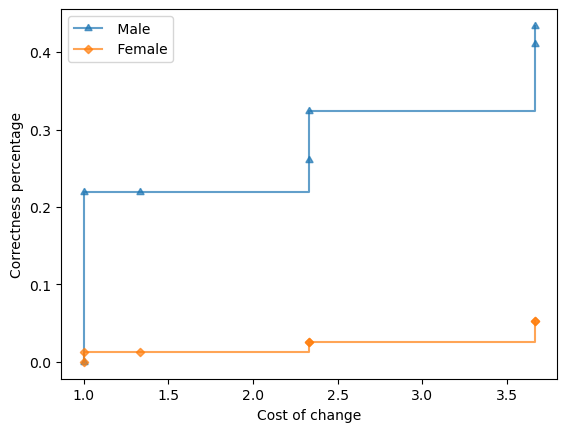

If capital-gain = 0, education-num = 9, native-country =  United-States, occupation =  Sales:
	Protected Subgroup ' Male', 3.27% covered out of 6761
		Make occupation =  Exec-managerial with correctness 21.40% and counterfactual cost = 1.0.
		Make education-num = 10 with correctness 21.40% and counterfactual cost = 1.33.
		Make education-num = 10, occupation =  Prof-specialty with correctness 25.76% and counterfactual cost = 2.33.
		Make education-num = 10, occupation =  Exec-managerial with correctness 31.88% and counterfactual cost = 2.33.
		Make education-num = 11, occupation =  Exec-managerial with correctness 42.79% and counterfactual cost = 3.67.
	Protected Subgroup ' Female', 4.11% covered out of 4067
		Make occupation =  Exec-managerial with correctness 1.09% and counterfactual cost = 1.0.
		Make education-num = 10 with correctness 1.09% and counterfactual cost = 1.33.
		Make education-num = 10, occupation =  Exec-managerial with correctness 2.19% and counterfactual cost = 2.33

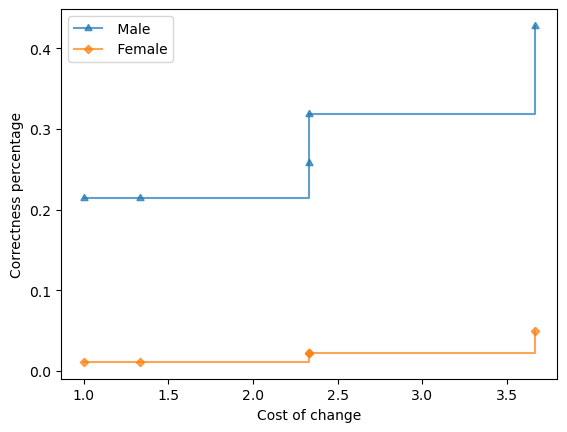

If capital-gain = 0, education-num = 9, native-country =  United-States, occupation =  Sales, race =  White:
	Protected Subgroup ' Male', 3.08% covered out of 6761
		Make occupation =  Exec-managerial with correctness 21.76% and counterfactual cost = 1.0.
		Make education-num = 10 with correctness 21.76% and counterfactual cost = 1.33.
		Make education-num = 10, occupation =  Prof-specialty with correctness 25.93% and counterfactual cost = 2.33.
		Make education-num = 10, occupation =  Exec-managerial with correctness 32.41% and counterfactual cost = 2.33.
		Make education-num = 11, occupation =  Exec-managerial with correctness 43.52% and counterfactual cost = 3.67.
	Protected Subgroup ' Female', 3.61% covered out of 4067
		Make occupation =  Exec-managerial with correctness 1.33% and counterfactual cost = 1.0.
		Make education-num = 10 with correctness 1.33% and counterfactual cost = 1.33.
		Make education-num = 10, occupation =  Exec-managerial with correctness 2.67% and counterfact

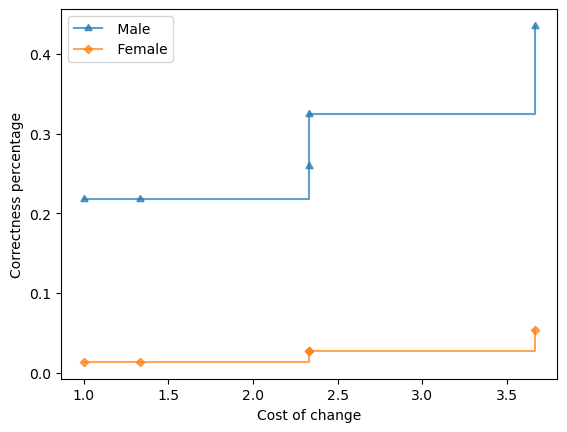

If capital-loss = 0, occupation =  Machine-op-inspct:
	Protected Subgroup ' Male', 9.21% covered out of 6761
		Make occupation =  Craft-repair with correctness 3.17% and counterfactual cost = 1.0.
		Make occupation =  Transport-moving with correctness 3.17% and counterfactual cost = 1.0.
		Make occupation =  Adm-clerical with correctness 4.12% and counterfactual cost = 1.0.
		Make occupation =  Protective-serv with correctness 10.46% and counterfactual cost = 1.0.
		Make occupation =  Sales with correctness 10.46% and counterfactual cost = 1.0.
		Make occupation =  Tech-support with correctness 10.62% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 13.00% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 16.96% and counterfactual cost = 1.0.
		Make capital-loss = 1902, occupation =  Prof-specialty with correctness 43.74% and counterfactual cost = 1.5.
		Make capital-loss = 1977, occupation =  Exec-managerial with co

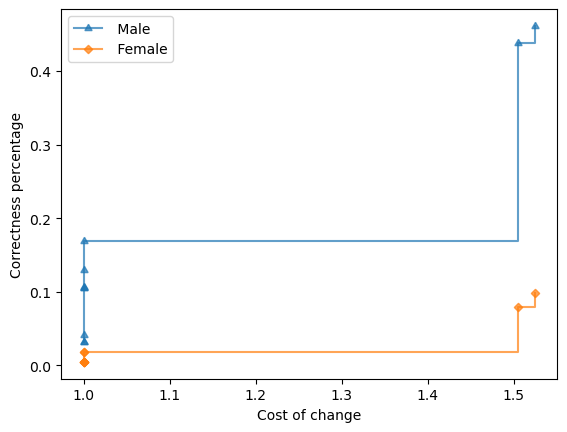

If Workclass =  Private, age = (26.0, 34.0], capital-gain = 0, native-country =  United-States, occupation =  Machine-op-inspct:
	Protected Subgroup ' Male', 1.88% covered out of 6761
		Make occupation =  Sales with correctness 3.82% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 5.34% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 5.34% and counterfactual cost = 1.0.
		Make age = (34.0, 41.0], occupation =  Sales with correctness 6.87% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Craft-repair with correctness 6.87% and counterfactual cost = 2.0.
		Make age = (34.0, 41.0], occupation =  Prof-specialty with correctness 21.37% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Sales with correctness 21.37% and counterfactual cost = 2.0.
		Make age = (34.0, 41.0], occupation =  Exec-managerial with correctness 24.43% and counterfactual cost = 2.0.
		Make age = (41.0, 

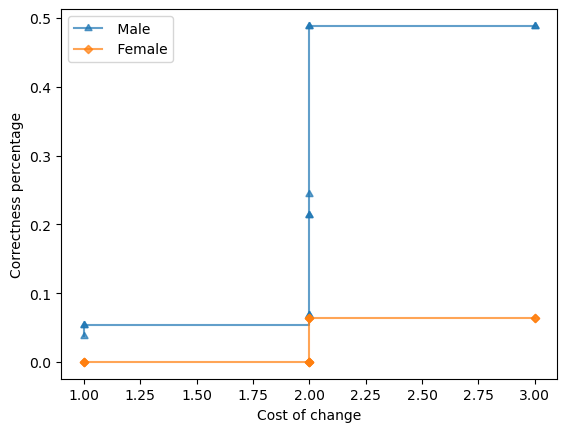

If capital-gain = 0, education-num = 9, occupation =  Sales:
	Protected Subgroup ' Male', 3.40% covered out of 6761
		Make occupation =  Exec-managerial with correctness 20.33% and counterfactual cost = 1.0.
		Make education-num = 10 with correctness 20.33% and counterfactual cost = 1.33.
		Make education-num = 10, occupation =  Prof-specialty with correctness 24.90% and counterfactual cost = 2.33.
		Make education-num = 10, occupation =  Exec-managerial with correctness 31.12% and counterfactual cost = 2.33.
		Make education-num = 11, occupation =  Exec-managerial with correctness 42.74% and counterfactual cost = 3.67.
	Protected Subgroup ' Female', 4.35% covered out of 4067
		Make occupation =  Exec-managerial with correctness 1.03% and counterfactual cost = 1.0.
		Make education-num = 10 with correctness 1.03% and counterfactual cost = 1.33.
		Make education-num = 10, occupation =  Exec-managerial with correctness 2.58% and counterfactual cost = 2.33.
		Make education-num = 10, occu

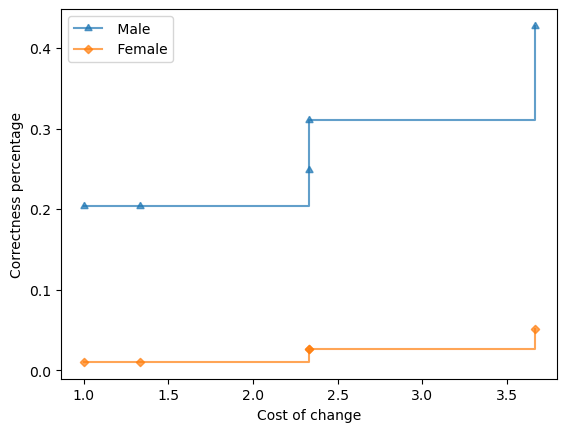

If age = (34.0, 41.0], capital-loss = 0, native-country =  United-States, occupation =  Adm-clerical:
	Protected Subgroup ' Male', 1.00% covered out of 6761
		Make occupation =  Craft-repair with correctness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Sales with correctness 9.86% and counterfactual cost = 1.0.
		Make age = (41.0, 50.0] with correctness 9.86% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 29.58% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 39.44% and counterfactual cost = 1.0.
		Make age = (50.0, 90.0], occupation =  Craft-repair with correctness 39.44% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Craft-repair with correctness 39.44% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Sales with correctness 39.44% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Sales with correctness 39.44% and counterfactual c

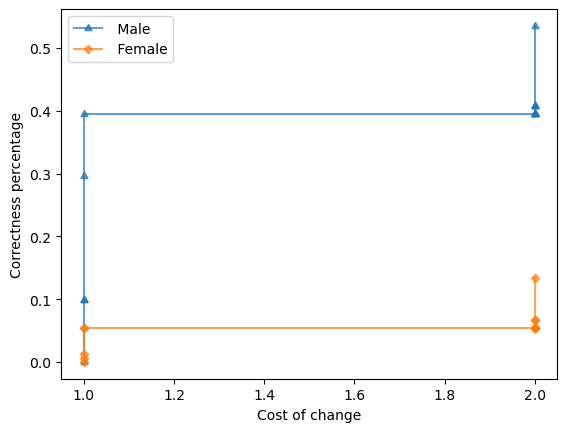

If age = (34.0, 41.0], capital-loss = 0, native-country =  United-States:
	Protected Subgroup ' Male', 15.55% covered out of 6761
		Make age = (50.0, 90.0] with correctness 3.66% and counterfactual cost = 1.0.
		Make age = (41.0, 50.0] with correctness 7.79% and counterfactual cost = 1.0.
		Make age = (41.0, 50.0], capital-loss = 1902 with correctness 52.11% and counterfactual cost = 1.5.
	Protected Subgroup ' Female', 15.35% covered out of 4067
		Make age = (50.0, 90.0] with correctness 0.00% and counterfactual cost = 1.0.
		Make age = (41.0, 50.0] with correctness 1.03% and counterfactual cost = 1.0.
		Make age = (41.0, 50.0], capital-loss = 1902 with correctness 17.59% and counterfactual cost = 1.5.
	 Unfairness based on the Kolmogorov-Smirnov test = 0.31.
	Cumulative correctness plot for the above recourses:


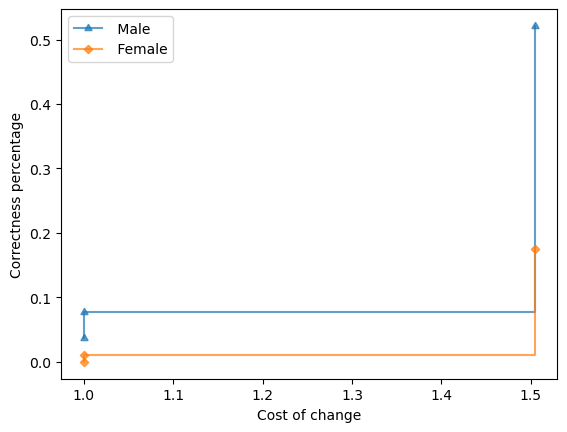

If education-num = 9, occupation =  Sales, race =  White:
	Protected Subgroup ' Male', 3.22% covered out of 6761
		Make occupation =  Craft-repair with correctness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Transport-moving with correctness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 21.24% and counterfactual cost = 1.0.
		Make education-num = 10 with correctness 21.24% and counterfactual cost = 1.33.
		Make education-num = 10, occupation =  Prof-specialty with correctness 25.66% and counterfactual cost = 2.33.
		Make education-num = 10, occupation =  Exec-managerial with correctness 32.30% and counterfactual cost = 2.33.
		Make education-num = 11, occupation =  Prof-specialty with correctness 41.15% and counterfactual cost = 3.67.
		Make education-num = 11, occupation =  Exec-managerial with correctness 43.36% and counterfactual cost = 3.67.
	Protected Subgroup ' Female', 3.85% covered out of 4067
		Make occupation =  Craft

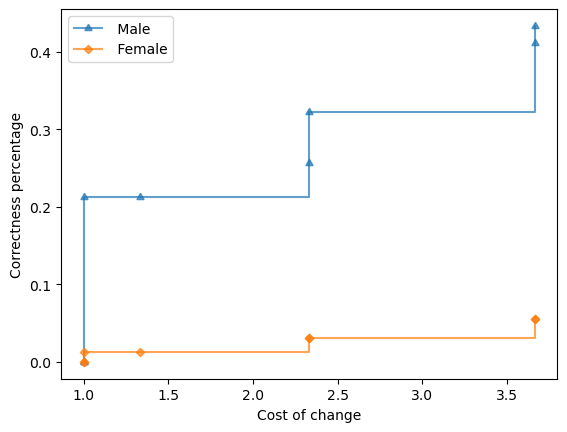

If Workclass =  Private, age = (50.0, 90.0], occupation =  Sales:
	Protected Subgroup ' Male', 1.12% covered out of 6761
		Make occupation =  Prof-specialty with correctness 35.38% and counterfactual cost = 1.0.
		Make Workclass =  Self-emp-inc with correctness 35.38% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 36.92% and counterfactual cost = 1.0.
		Make Workclass =  Self-emp-inc, occupation =  Prof-specialty with correctness 36.92% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with correctness 47.69% and counterfactual cost = 2.0.
	Protected Subgroup ' Female', 1.64% covered out of 4067
		Make occupation =  Exec-managerial with correctness 4.55% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 4.55% and counterfactual cost = 1.0.
		Make Workclass =  Self-emp-inc with correctness 4.55% and counterfactual cost = 1.0.
		Make Workclass =  Self-emp-inc, occupation =

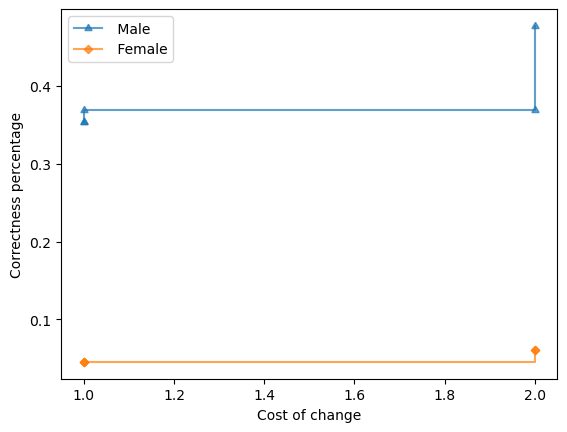

If capital-loss = 0, education-num = 9, native-country =  United-States, occupation =  Sales, race =  White:
	Protected Subgroup ' Male', 3.09% covered out of 6761
		Make occupation =  Craft-repair with correctness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 21.86% and counterfactual cost = 1.0.
		Make education-num = 10 with correctness 21.86% and counterfactual cost = 1.33.
		Make education-num = 10, occupation =  Prof-specialty with correctness 26.05% and counterfactual cost = 2.33.
		Make education-num = 10, occupation =  Exec-managerial with correctness 32.56% and counterfactual cost = 2.33.
		Make education-num = 11, occupation =  Exec-managerial with correctness 43.26% and counterfactual cost = 3.67.
	Protected Subgroup ' Female', 3.66% covered out of 4067
		Make occupation =  Craft-repair with correctness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 1.33% and counterfactual cost = 1.0.


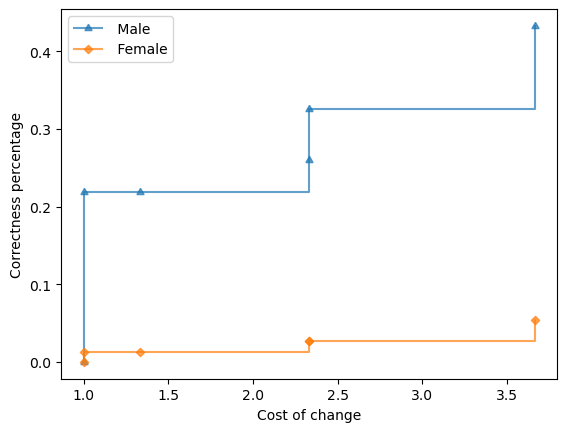

If capital-gain = 0, education-num = 9, occupation =  Sales, race =  White:
	Protected Subgroup ' Male', 3.12% covered out of 6761
		Make occupation =  Exec-managerial with correctness 21.08% and counterfactual cost = 1.0.
		Make education-num = 10 with correctness 21.08% and counterfactual cost = 1.33.
		Make education-num = 10, occupation =  Prof-specialty with correctness 25.56% and counterfactual cost = 2.33.
		Make education-num = 10, occupation =  Exec-managerial with correctness 32.29% and counterfactual cost = 2.33.
		Make education-num = 11, occupation =  Exec-managerial with correctness 43.50% and counterfactual cost = 3.67.
	Protected Subgroup ' Female', 3.75% covered out of 4067
		Make occupation =  Exec-managerial with correctness 1.27% and counterfactual cost = 1.0.
		Make education-num = 10 with correctness 1.27% and counterfactual cost = 1.33.
		Make education-num = 10, occupation =  Exec-managerial with correctness 3.16% and counterfactual cost = 2.33.
		Make education

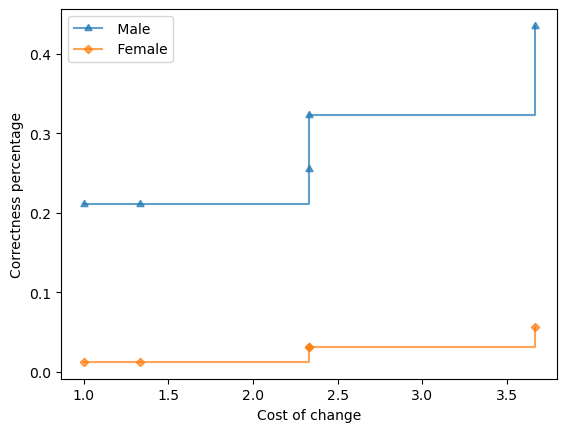

If capital-gain = 0, capital-loss = 0, education-num = 9, native-country =  United-States, occupation =  Sales:
	Protected Subgroup ' Male', 3.18% covered out of 6761
		Make occupation =  Exec-managerial with correctness 21.33% and counterfactual cost = 1.0.
		Make education-num = 10 with correctness 21.33% and counterfactual cost = 1.33.
		Make education-num = 10, occupation =  Prof-specialty with correctness 25.78% and counterfactual cost = 2.33.
		Make education-num = 10, occupation =  Exec-managerial with correctness 32.00% and counterfactual cost = 2.33.
		Make education-num = 11, occupation =  Exec-managerial with correctness 42.67% and counterfactual cost = 3.67.
	Protected Subgroup ' Female', 4.04% covered out of 4067
		Make occupation =  Exec-managerial with correctness 1.12% and counterfactual cost = 1.0.
		Make education-num = 10 with correctness 1.12% and counterfactual cost = 1.33.
		Make education-num = 10, occupation =  Exec-managerial with correctness 2.23% and counterf

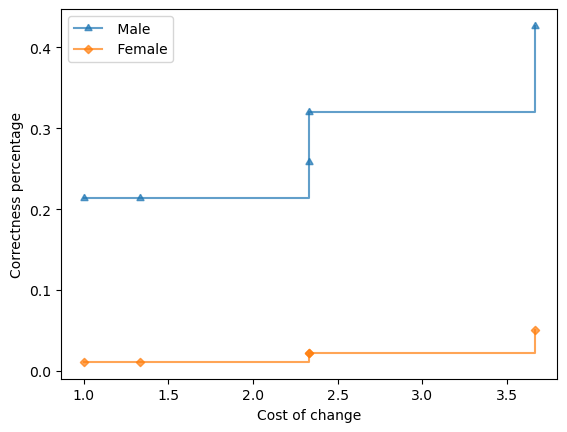

If capital-gain = 0, capital-loss = 0, education-num = 9, native-country =  United-States, occupation =  Sales, race =  White:
	Protected Subgroup ' Male', 2.99% covered out of 6761
		Make occupation =  Exec-managerial with correctness 21.70% and counterfactual cost = 1.0.
		Make education-num = 10 with correctness 21.70% and counterfactual cost = 1.33.
		Make education-num = 10, occupation =  Prof-specialty with correctness 25.94% and counterfactual cost = 2.33.
		Make education-num = 10, occupation =  Exec-managerial with correctness 32.55% and counterfactual cost = 2.33.
		Make education-num = 11, occupation =  Exec-managerial with correctness 43.40% and counterfactual cost = 3.67.
	Protected Subgroup ' Female', 3.56% covered out of 4067
		Make occupation =  Exec-managerial with correctness 1.36% and counterfactual cost = 1.0.
		Make education-num = 10 with correctness 1.36% and counterfactual cost = 1.33.
		Make education-num = 10, occupation =  Exec-managerial with correctness 2.7

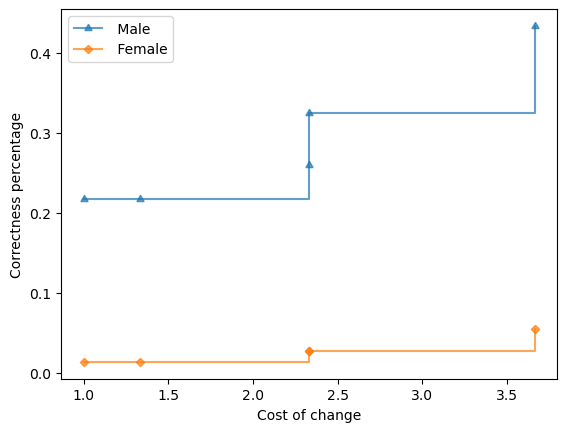

If education-num = 9, native-country =  United-States, occupation =  Sales:
	Protected Subgroup ' Male', 3.39% covered out of 6761
		Make occupation =  Craft-repair with correctness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 21.37% and counterfactual cost = 1.0.
		Make education-num = 10 with correctness 21.37% and counterfactual cost = 1.33.
		Make education-num = 10, occupation =  Craft-repair with correctness 21.37% and counterfactual cost = 2.33.
		Make education-num = 10, occupation =  Prof-specialty with correctness 25.64% and counterfactual cost = 2.33.
		Make education-num = 10, occupation =  Exec-managerial with correctness 31.62% and counterfactual cost = 2.33.
		Make education-num = 11, occupation =  Prof-specialty with correctness 40.17% and counterfactual cost = 3.67.
		Make education-num = 11, occupation =  Exec-managerial with correctness 42.31% and counterfactual cost = 3.67.
	Protected Subgroup ' Female', 4.21% covered ou

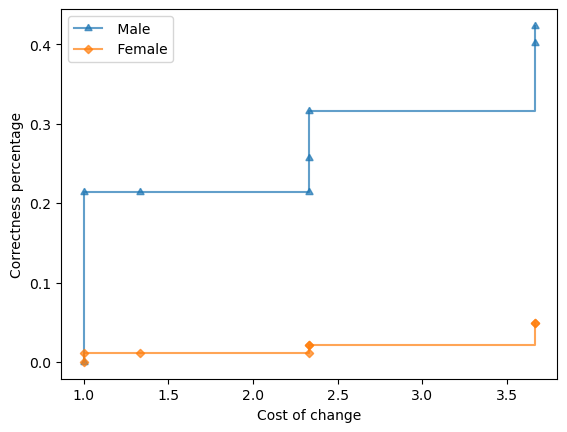

If capital-gain = 0, capital-loss = 0, marital-status =  Never-married, native-country =  United-States, occupation =  Sales, race =  White, relationship =  Own-child:
	Protected Subgroup ' Male', 1.43% covered out of 6761
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 3.88% and counterfactual cost = 11.0.
		Make marital-status =  Married-civ-spouse, occupation =  Craft-repair, relationship =  Married with correctness 3.88% and counterfactual cost = 12.0.
		Make marital-status =  Married-civ-spouse, occupation =  Adm-clerical, relationship =  Married with correctness 3.88% and counterfactual cost = 12.0.
		Make marital-status =  Married-civ-spouse, occupation =  Tech-support, relationship =  Married with correctness 8.74% and counterfactual cost = 12.0.
		Make marital-status =  Married-civ-spouse, occupation =  Prof-specialty, relationship =  Married with correctness 8.74% and counterfactual cost = 12.0.
		Make marital-status =  Married-civ-spouse

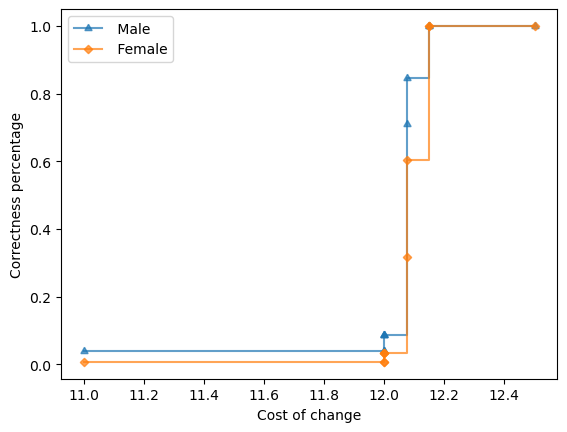

If Workclass =  Private, age = (50.0, 90.0], capital-gain = 0, occupation =  Sales:
	Protected Subgroup ' Male', 1.07% covered out of 6761
		Make occupation =  Prof-specialty with correctness 35.38% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 36.92% and counterfactual cost = 1.0.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with correctness 47.69% and counterfactual cost = 2.0.
	Protected Subgroup ' Female', 1.61% covered out of 4067
		Make occupation =  Exec-managerial with correctness 4.55% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 4.55% and counterfactual cost = 1.0.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with correctness 6.06% and counterfactual cost = 2.0.
	 Unfairness based on the Kolmogorov-Smirnov test = 0.31.
	Cumulative correctness plot for the above recourses:


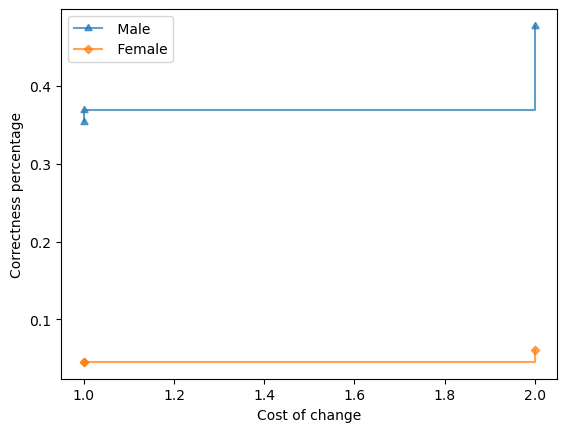

If capital-gain = 0, capital-loss = 0, education-num = 9, occupation =  Sales:
	Protected Subgroup ' Male', 3.31% covered out of 6761
		Make occupation =  Exec-managerial with correctness 20.25% and counterfactual cost = 1.0.
		Make education-num = 10 with correctness 20.25% and counterfactual cost = 1.33.
		Make education-num = 10, occupation =  Prof-specialty with correctness 24.89% and counterfactual cost = 2.33.
		Make education-num = 10, occupation =  Exec-managerial with correctness 31.22% and counterfactual cost = 2.33.
		Make education-num = 11, occupation =  Exec-managerial with correctness 42.62% and counterfactual cost = 3.67.
	Protected Subgroup ' Female', 4.28% covered out of 4067
		Make occupation =  Exec-managerial with correctness 1.05% and counterfactual cost = 1.0.
		Make education-num = 10 with correctness 1.05% and counterfactual cost = 1.33.
		Make education-num = 10, occupation =  Exec-managerial with correctness 2.63% and counterfactual cost = 2.33.
		Make educat

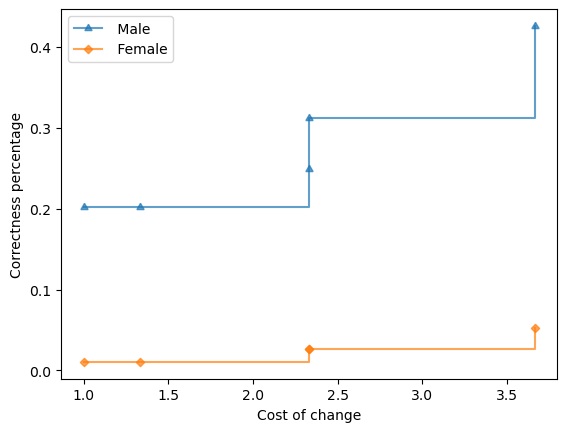

If education-num = 9, occupation =  Sales:
	Protected Subgroup ' Male', 3.52% covered out of 6761
		Make occupation =  Craft-repair with correctness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Transport-moving with correctness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 20.33% and counterfactual cost = 1.0.
		Make education-num = 10 with correctness 20.33% and counterfactual cost = 1.33.
		Make education-num = 10, occupation =  Craft-repair with correctness 20.33% and counterfactual cost = 2.33.
		Make education-num = 10, occupation =  Prof-specialty with correctness 24.80% and counterfactual cost = 2.33.
		Make education-num = 10, occupation =  Exec-managerial with correctness 30.89% and counterfactual cost = 2.33.
		Make education-num = 11, occupation =  Prof-specialty with correctness 40.24% and counterfactual cost = 3.67.
		Make education-num = 11, occupation =  Exec-managerial with correctness 42.28% and counterfactual c

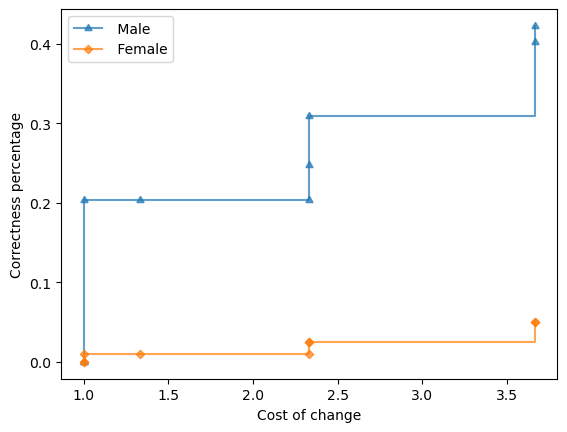

If Workclass =  Private, age = (50.0, 90.0], capital-loss = 0, native-country =  United-States, occupation =  Sales:
	Protected Subgroup ' Male', 1.06% covered out of 6761
		Make occupation =  Exec-managerial with correctness 37.10% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 37.10% and counterfactual cost = 1.0.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with correctness 46.77% and counterfactual cost = 2.0.
	Protected Subgroup ' Female', 1.52% covered out of 4067
		Make occupation =  Exec-managerial with correctness 5.00% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 5.00% and counterfactual cost = 1.0.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with correctness 5.00% and counterfactual cost = 2.0.
	 Unfairness based on the Kolmogorov-Smirnov test = 0.31.
	Cumulative correctness plot for the above recourses:


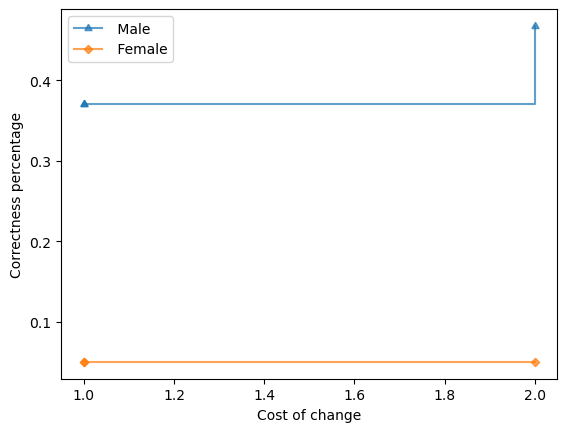

If capital-loss = 0, education-num = 9, occupation =  Sales, race =  White:
	Protected Subgroup ' Male', 3.13% covered out of 6761
		Make occupation =  Craft-repair with correctness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 21.17% and counterfactual cost = 1.0.
		Make education-num = 10 with correctness 21.17% and counterfactual cost = 1.33.
		Make education-num = 10, occupation =  Prof-specialty with correctness 25.68% and counterfactual cost = 2.33.
		Make education-num = 10, occupation =  Exec-managerial with correctness 32.43% and counterfactual cost = 2.33.
		Make education-num = 11, occupation =  Exec-managerial with correctness 43.24% and counterfactual cost = 3.67.
	Protected Subgroup ' Female', 3.80% covered out of 4067
		Make occupation =  Craft-repair with correctness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 1.27% and counterfactual cost = 1.0.
		Make education-num = 10 with co

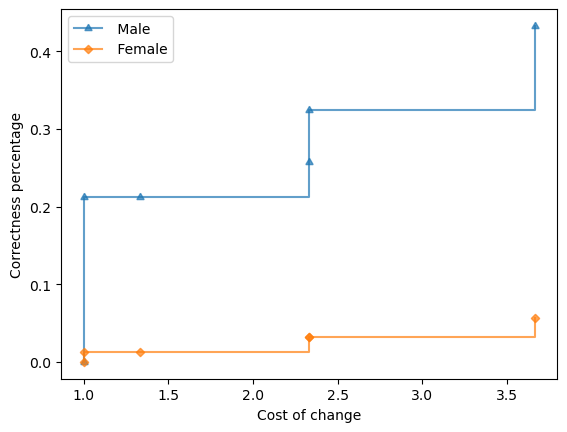

If age = (26.0, 34.0], native-country =  United-States, occupation =  Machine-op-inspct:
	Protected Subgroup ' Male', 2.03% covered out of 6761
		Make occupation =  Sales with correctness 4.23% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 6.34% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 7.04% and counterfactual cost = 1.0.
		Make age = (34.0, 41.0], occupation =  Craft-repair with correctness 7.04% and counterfactual cost = 2.0.
		Make age = (34.0, 41.0], occupation =  Sales with correctness 8.45% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Craft-repair with correctness 8.45% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Adm-clerical with correctness 9.15% and counterfactual cost = 2.0.
		Make age = (34.0, 41.0], occupation =  Prof-specialty with correctness 21.83% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Sales with correc

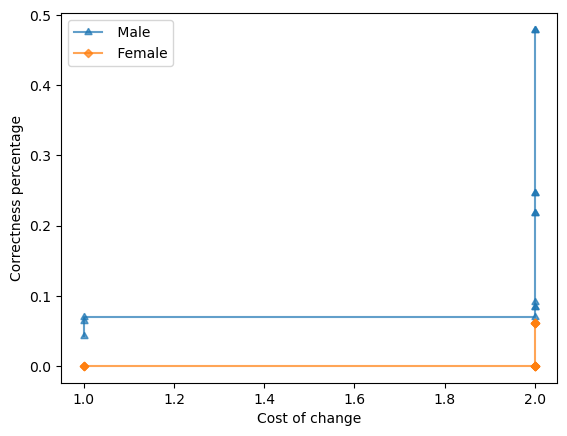

If capital-gain = 0, capital-loss = 0, education-num = 9, occupation =  Sales, race =  White:
	Protected Subgroup ' Male', 3.03% covered out of 6761
		Make occupation =  Exec-managerial with correctness 21.00% and counterfactual cost = 1.0.
		Make education-num = 10 with correctness 21.00% and counterfactual cost = 1.33.
		Make education-num = 10, occupation =  Prof-specialty with correctness 25.57% and counterfactual cost = 2.33.
		Make education-num = 10, occupation =  Exec-managerial with correctness 32.42% and counterfactual cost = 2.33.
		Make education-num = 11, occupation =  Exec-managerial with correctness 43.38% and counterfactual cost = 3.67.
	Protected Subgroup ' Female', 3.70% covered out of 4067
		Make occupation =  Exec-managerial with correctness 1.29% and counterfactual cost = 1.0.
		Make education-num = 10 with correctness 1.29% and counterfactual cost = 1.33.
		Make education-num = 10, occupation =  Exec-managerial with correctness 3.23% and counterfactual cost = 2.33

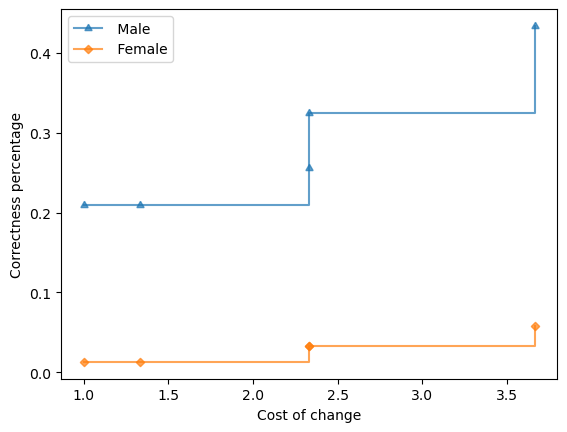

If capital-gain = 0, capital-loss = 0, marital-status =  Never-married, occupation =  Sales, race =  White, relationship =  Own-child:
	Protected Subgroup ' Male', 1.48% covered out of 6761
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 4.72% and counterfactual cost = 11.0.
		Make marital-status =  Married-civ-spouse, occupation =  Craft-repair, relationship =  Married with correctness 4.72% and counterfactual cost = 12.0.
		Make marital-status =  Married-civ-spouse, occupation =  Adm-clerical, relationship =  Married with correctness 4.72% and counterfactual cost = 12.0.
		Make marital-status =  Married-civ-spouse, occupation =  Tech-support, relationship =  Married with correctness 9.43% and counterfactual cost = 12.0.
		Make marital-status =  Married-civ-spouse, occupation =  Prof-specialty, relationship =  Married with correctness 9.43% and counterfactual cost = 12.0.
		Make marital-status =  Married-civ-spouse, occupation =  Exec-managerial, 

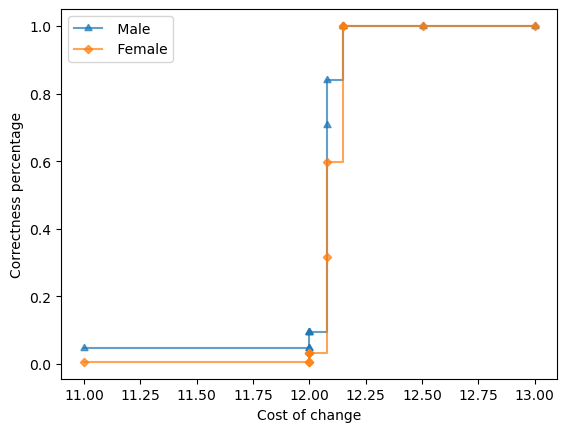

If capital-loss = 0, education-num = 9, native-country =  United-States, occupation =  Sales:
	Protected Subgroup ' Male', 3.30% covered out of 6761
		Make occupation =  Craft-repair with correctness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 21.30% and counterfactual cost = 1.0.
		Make education-num = 10 with correctness 21.30% and counterfactual cost = 1.33.
		Make education-num = 10, occupation =  Prof-specialty with correctness 25.65% and counterfactual cost = 2.33.
		Make education-num = 10, occupation =  Exec-managerial with correctness 31.74% and counterfactual cost = 2.33.
		Make education-num = 11, occupation =  Exec-managerial with correctness 42.17% and counterfactual cost = 3.67.
	Protected Subgroup ' Female', 4.14% covered out of 4067
		Make occupation =  Craft-repair with correctness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 1.10% and counterfactual cost = 1.0.
		Make educatio

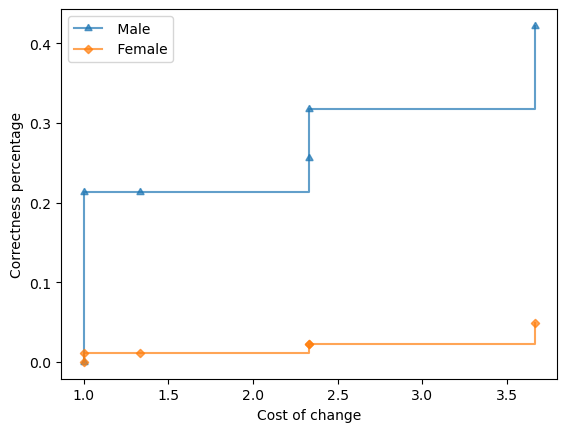

If age = (41.0, 50.0], capital-loss = 0:
	Protected Subgroup ' Male', 14.52% covered out of 6761
		Make capital-loss = 1902 with correctness 49.46% and counterfactual cost = 0.5.
		Make age = (50.0, 90.0] with correctness 49.46% and counterfactual cost = 1.0.
	Protected Subgroup ' Female', 15.11% covered out of 4067
		Make capital-loss = 1902 with correctness 15.40% and counterfactual cost = 0.5.
		Make age = (50.0, 90.0] with correctness 15.40% and counterfactual cost = 1.0.
	 Unfairness based on the Kolmogorov-Smirnov test = 0.31.
	Cumulative correctness plot for the above recourses:


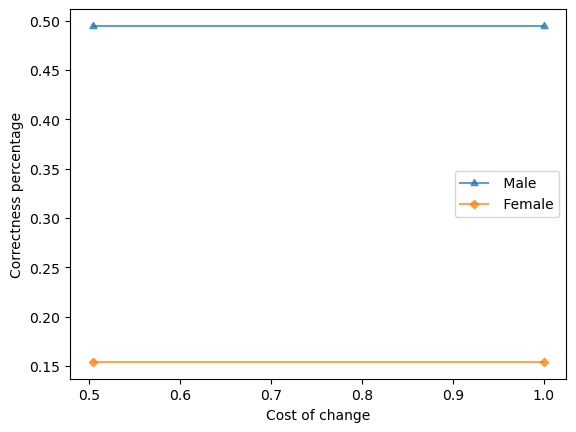

If age = (34.0, 41.0], capital-loss = 0, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 13.99% covered out of 6761
		Make age = (50.0, 90.0] with correctness 3.98% and counterfactual cost = 1.0.
		Make age = (41.0, 50.0] with correctness 8.28% and counterfactual cost = 1.0.
		Make age = (41.0, 50.0], capital-loss = 1902 with correctness 54.09% and counterfactual cost = 1.5.
	Protected Subgroup ' Female', 12.00% covered out of 4067
		Make age = (50.0, 90.0] with correctness 0.00% and counterfactual cost = 1.0.
		Make age = (41.0, 50.0] with correctness 0.87% and counterfactual cost = 1.0.
		Make age = (41.0, 50.0], capital-loss = 1902 with correctness 19.78% and counterfactual cost = 1.5.
	 Unfairness based on the Kolmogorov-Smirnov test = 0.31.
	Cumulative correctness plot for the above recourses:


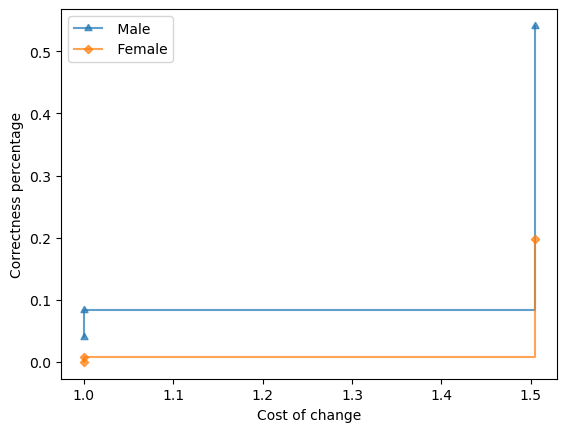

If age = (34.0, 41.0], occupation =  Adm-clerical:
	Protected Subgroup ' Male', 1.10% covered out of 6761
		Make occupation =  Craft-repair with correctness 0.00% and counterfactual cost = 1.0.
		Make age = (50.0, 90.0] with correctness 5.00% and counterfactual cost = 1.0.
		Make age = (41.0, 50.0] with correctness 11.25% and counterfactual cost = 1.0.
		Make occupation =  Sales with correctness 11.25% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 28.75% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 37.50% and counterfactual cost = 1.0.
		Make age = (50.0, 90.0], occupation =  Craft-repair with correctness 37.50% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Craft-repair with correctness 37.50% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Sales with correctness 37.50% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Sales with correctn

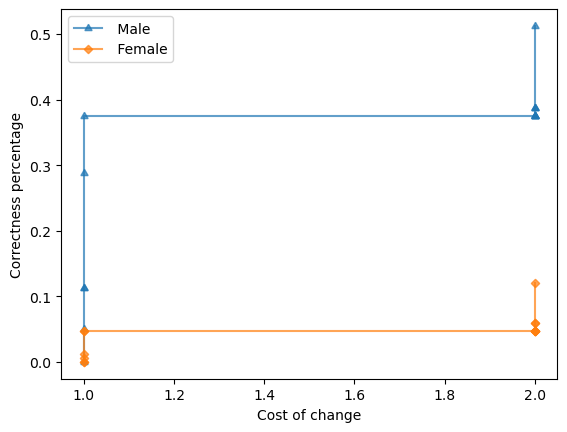

In [20]:
affected_pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}

top_rules,unfairness = facts.select_rules_subset_KStest(
    rules_with_cumulative,
    affected_pop_sizes,
    top_count=50
)

print_recourse_report_KStest_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    unfairness = unfairness,
    show_then_costs=True,
    show_cumulative_plots=True
)